# <div style='text-align: center;'> **Projet Gaming** - Partie 2 : Analyses descriptives et prédictives des données </div>

## Importation des bibliothèques et des données


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.widgets import Slider
import scipy.stats as stats
from scipy.stats import pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import combinations

# Installation de panel si nécessaire (pour interactivité avec les graphiques)
# !pip install panel matplotlib
import panel as pn
pn.extension()

df_IGDB = pd.read_csv('IGDB_jeux_rpg.csv')
# display(df_IGDB)

df_Steam = pd.read_csv('steam_jeux_rpg.csv')
# display(df_Steam.head())

df = pd.read_csv('jeux_rpg.csv')
# display(df.head())

## Exploration des données

### 1 - Exploration des métadonnées (df_IGDB)

In [78]:
# Pour plus de confort, je travaillerai dans un premier temps sur un dataframe excluant les résumés
df_IGDB_withoutResume = df_IGDB.drop(columns=['Résumé'])

# Exploration du nombre de jeux par plateforme, développeur/éditeur et mode de jeu
nbrDistinctValues_Plateformes = df_IGDB_withoutResume['Plateformes'].nunique()
nbrDistinctValues_DeveloppeursEditeurs = df_IGDB_withoutResume['Développeurs/Éditeurs'].nunique()
nbrDistinctValues_ModesDeJeu = df_IGDB_withoutResume['Modes de jeu'].nunique()

print(len(df_IGDB_withoutResume))
print(nbrDistinctValues_Plateformes, nbrDistinctValues_DeveloppeursEditeurs, nbrDistinctValues_ModesDeJeu) 
# Pour nbrDistinctValues_DeveloppeursEditeurs : 66/74 jeux => quasiment tous les jeux sont développés/édités par différents groupes, donc je ne réaliserai donc pas de barplot de leur répartition par développeur/éditeur

74
40 66 9


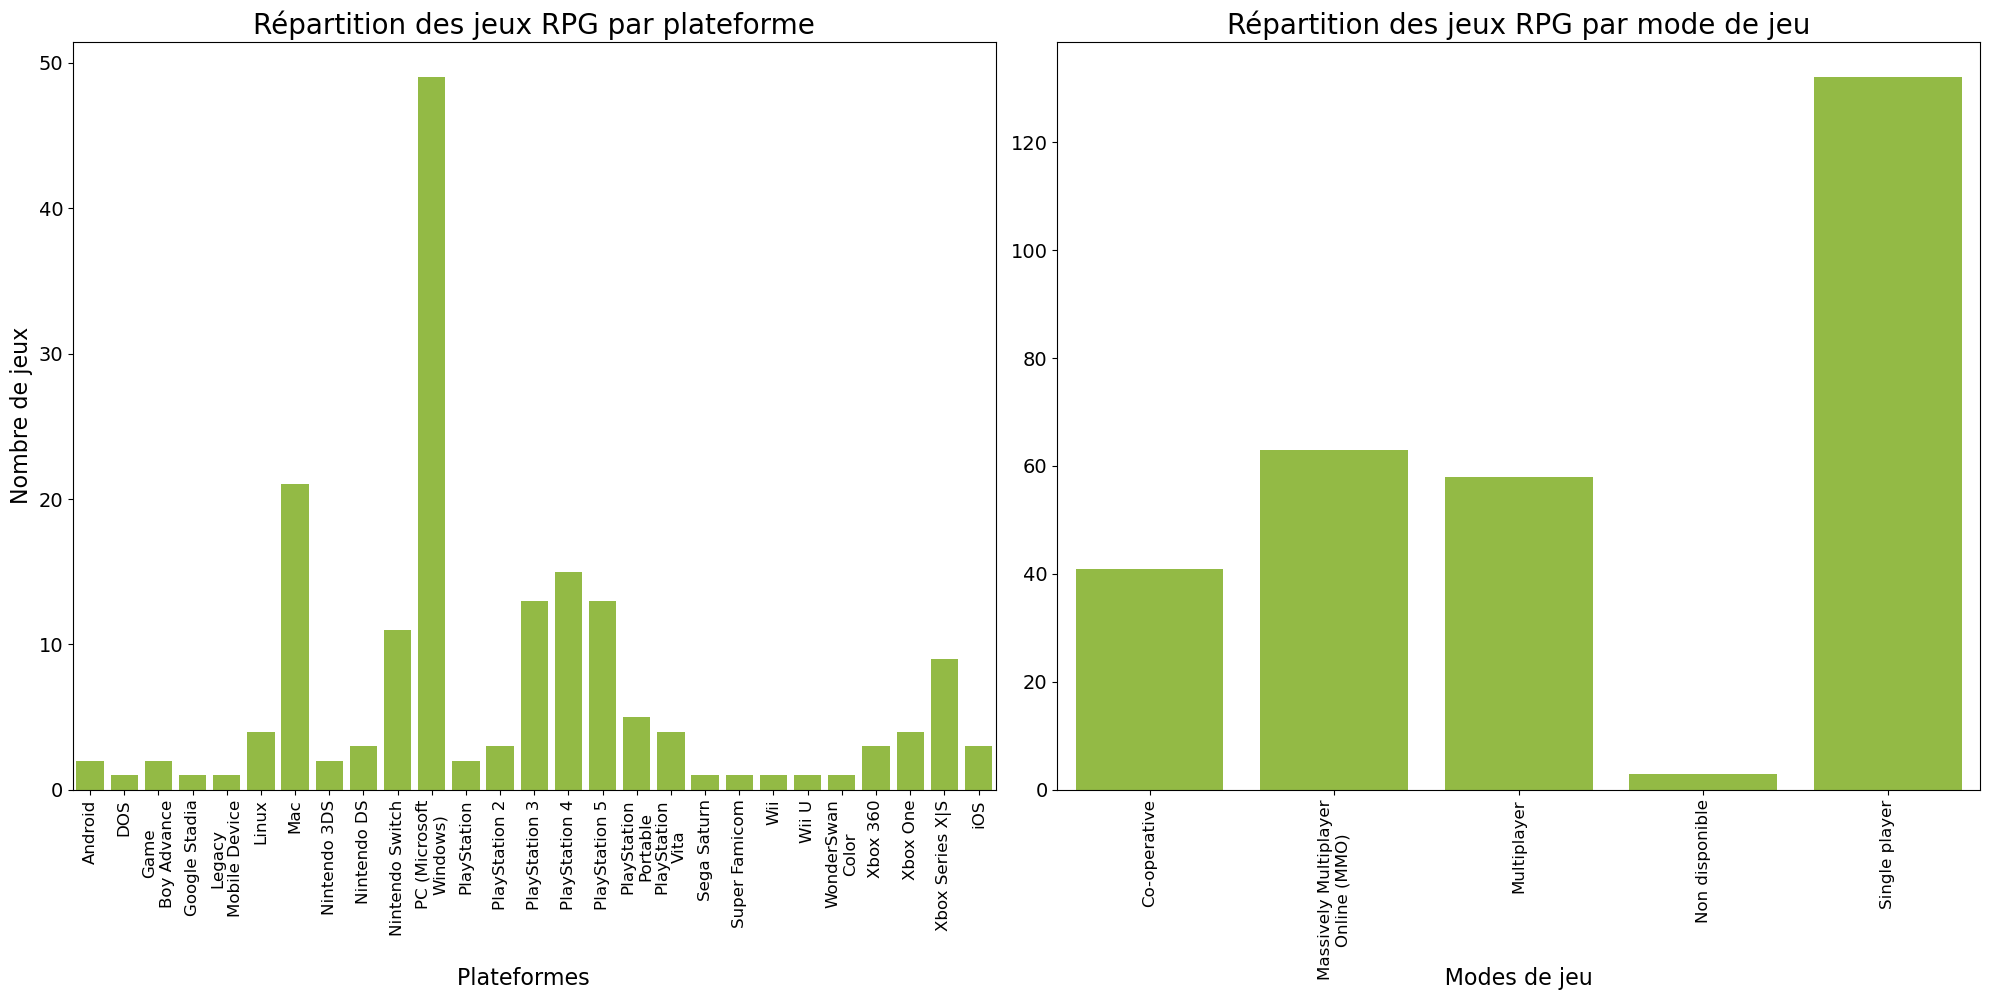

In [79]:
# Fonction pour couper les étiquettes longues en deux lignes
def split_label(label, max_length=15):
    # Couper en deux si la longueur dépasse max_length
    if len(label) > max_length:
        mid = len(label) // 2  # Trouve le milieu approximatif
        split_index = label.find(' ', mid-5, mid+5)  # Trouve un espace proche du milieu pour couper
        if split_index == -1:
            split_index = mid  # Si pas d'espace trouvé, coupe au milieu
        return label[:split_index] + '\n' + label[split_index:].strip()
    return label

# Diagramme à barres de la répartition des jeux par plateforme et par mode de jeu

# Préparation des données
df_IGDB_withoutResume['Plateformes'] = df_IGDB_withoutResume['Plateformes'].str.split(', ')
df_IGDB_withoutResume['Modes de jeu'] = df_IGDB_withoutResume['Modes de jeu'].str.split(', ')

# Éclatement des plateformes et des modes de jeu qui sont séparées par des virgules
df_IGDB_plateformes = df_IGDB_withoutResume.explode('Plateformes')
df_IGDB_modes = df_IGDB_plateformes.explode('Modes de jeu')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Fonction pour faire apparaître les deux diagrammes à barres
def plot_distribution(data, column, ax, title, color='yellowgreen', max_length=15):
    counts = data[column].value_counts().sort_index()
    
    new_index = [split_label(str(label), max_length) for label in counts.index]  # Applique la coupure des étiquettes
    
    sns.barplot(x=new_index, y=counts.values, ax=ax, color=color)
    ax.set_title(title, fontsize=20)
    # ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Nombre de jeux', fontsize=16)
    ax.tick_params(axis='x', rotation=90)  
    
    # Ajustement des dimensions des étiquettes des axes
    plt.setp(ax.get_xticklabels(), fontsize=12, ha='center')
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
# Tracé des graphiques
plot_distribution(df_IGDB_plateformes, 'Plateformes', ax1, 'Répartition des jeux RPG par plateforme')
plot_distribution(df_IGDB_modes, 'Modes de jeu', ax2, 'Répartition des jeux RPG par mode de jeu')

ax2.set_ylabel('')  # Supprime le libellé de l'axe des y du second graphique

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()

fig.text(0.515, 0.01, 'Plateformes                                                                                                                        Modes de jeu', 
         ha='center', fontsize=16) # Aligne les libellés de l'axe des x 

plt.show()

Le nombre de jeux RPG joués sur PC est conséquent : cela confirme la pertinence d'une analyse via *Steam* (plateforme de jeux sur PC).  
Les RPG les mieux notés sont essentiellement des jeux Single player (un seul joueur).

### 2 - Exploration des statistiques (df global)

In [80]:
# Transformation des données (cleaning)
# Pour plus de confort, je travaillerai dans un premier temps sur un dataframe excluant les résumés
df_withoutResume = df.drop(columns=['Résumé'])

# Transformation en float des colonnes 'Prix' et 'Revenus Approximatifs' 
df_withoutResume['Prix'] = df_withoutResume['Prix'].replace('Gratuit', '0.00 €')
df_withoutResume['Prix'] = df_withoutResume['Prix'].replace('Non disponible', np.nan)
df_withoutResume['Prix'] = df_withoutResume['Prix'].str.replace('€', '')
df_withoutResume['Prix'] = df_withoutResume['Prix'].astype(float)

df_withoutResume['Revenus Approximatifs'] = df_withoutResume['Revenus Approximatifs'].replace('Non disponible', np.nan)
df_withoutResume['Revenus Approximatifs'] = df_withoutResume['Revenus Approximatifs'].str.replace(',', '') # Nettoyage des milliers (suppression des virgules)
df_withoutResume['Revenus Approximatifs'] = df_withoutResume['Revenus Approximatifs'].str.replace('€', '')
df_withoutResume['Revenus Approximatifs'] = df_withoutResume['Revenus Approximatifs'].astype(float)
df_withoutResume['Revenus Approximatifs'] = df_withoutResume['Revenus Approximatifs']/1000000 # Division par 1 000 000 pour obtenir les nombres en millions d'euros
df_withoutResume = df_withoutResume.rename(columns={'Revenus Approximatifs': 'Revenus Approximatifs (millions)'}) # Modification du nom de la colonne


# Transformation en integer des colonnes 'Score Metacritic' et 'Recommandations Positives'
df_withoutResume['Score Metacritic'] = df_withoutResume['Score Metacritic'].astype('Int64')
df_withoutResume['Recommandations Positives'] = df_withoutResume['Recommandations Positives'].astype('Int64')


# Mise en format date de la colonne 'Date de sortie'
df_withoutResume['Date de sortie'] = pd.to_datetime(df_withoutResume['Date de sortie']) 

# Création d'une colonne 'Année' pour extraire l'année de sortie uniquement
df_withoutResume['Année'] = df_withoutResume['Date de sortie'].dt.year 


# Coupure de la colonne 'Propriétaires' en deux nouvelles colonnes : 'Propriétaires Min' et 'Propriétaires Max' pour les bornes minimale et maximale du nombre de joueurs possédant le jeu
# Split sur ' .. ' (avec les espaces autour)
split_cols = df_withoutResume['Propriétaires'].str.split(' .. ', expand=True)

# Attribution des colonnes
df_withoutResume['Propriétaires Min'] = split_cols[0] # Remplit avec ce qu'il y a avant ' .. '
df_withoutResume['Propriétaires Max'] = split_cols[1] # Remplit avec ce qu'il y a après ' .. '

# Nettoyage des milliers (suppression des virgules) et conversion en integer
df_withoutResume['Propriétaires Min'] = df_withoutResume['Propriétaires Min'].str.replace(',', '').astype(int)
df_withoutResume['Propriétaires Max'] = df_withoutResume['Propriétaires Max'].str.replace(',', '').astype(int)

# Création d'une colonne 'Moyenne de Propriétaires' (moyenne des bornes min et max) où le nombre de propriétaires moyen est exprimé en millions (division par 1 000 000)
df_withoutResume['Nombre Moyen de Propriétaires (millions)'] = (df_withoutResume['Propriétaires Max']+df_withoutResume['Propriétaires Min'])/2/1000000

# Suppression des colonnes initiale, min et max 
df_withoutResume = df_withoutResume.drop(['Propriétaires', 'Propriétaires Max', 'Propriétaires Min'], axis=1)


# Vérification
display(df_withoutResume.head())
# print(df_withoutResume.dtypes)

,Nom,Date de sortie,Note,Plateformes,Développeurs/Éditeurs,Modes de jeu,AppID Steam,Prix,Joueurs Actuels,Score Metacritic,Recommandations Positives,Revenus Approximatifs (millions),Année,Nombre Moyen de Propriétaires (millions)
0,Final Fantasy XIV: Heavensward,2015-06-23,86.89,"Xbox Series X|S, PlayStation 3, PlayStation 4,...","Square Enix, Square Enix Business Division 5, ...","Single player, Multiplayer, Co-operative, Mass...",39210,9.99,16543,83,72896,34.965,2015,3.5
1,Albion Online,2017-07-17,87.50,"Linux, Android, PC (Microsoft Windows), iOS, Mac",Sandbox Interactive,"Multiplayer, Massively Multiplayer Online (MMO)",761890,0.00,10533,<NA>,1869,NaN,2017,3.5
2,Grim Dawn: Definitive Edition,2019-12-31,85.00,"PC (Microsoft Windows), Xbox One",Crate Entertainment,"Single player, Multiplayer, Co-operative",219990,24.99,3204,83,83299,374.850,2019,15.0
3,Star Wars: The Old Republic,2011-12-20,85.00,"PC (Microsoft Windows), Mac","Electronic Arts, BioWare Austin, LucasArts, Bi...","Multiplayer, Co-operative, Massively Multiplay...",1286830,0.00,3147,85,410,NaN,2011,7.5
4,Guild Wars 2,2017-09-22,83.75,"PC (Microsoft Windows), Mac",ArenaNet,Massively Multiplayer Online (MMO),1284210,0.00,2867,90,339,NaN,2017,3.5


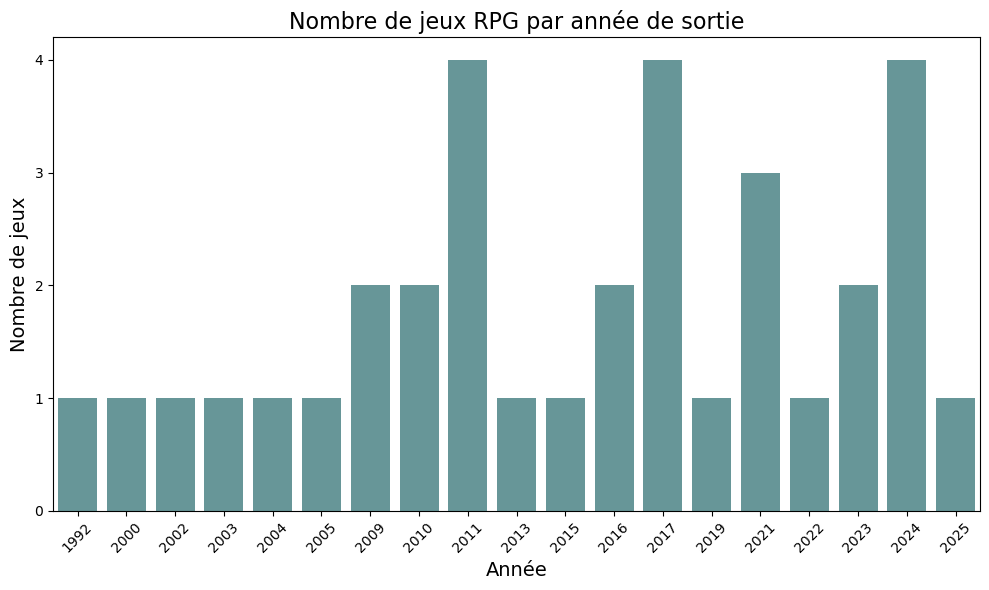

In [81]:
# Diagramme à barres de la répartition des jeux par année de sortie (variable discrète)
donnees_par_annee = df_withoutResume.groupby('Année').size().reset_index(name='count') # Aggrégation des dates de sortie par année de sortie

plt.figure(figsize=(10, 6))
sns.barplot(x='Année', y='count', data=donnees_par_annee, color='cadetblue')
plt.title('Nombre de jeux RPG par année de sortie', fontsize=16)
plt.xlabel('Année', fontsize=14)
plt.ylabel('Nombre de jeux', fontsize=14)
y_max = donnees_par_annee['count'].max() 
yticks = np.arange(0, y_max + 1, 1) # Création d'une séquence d'entiers allant de 0 au maximum + 1 pour les graduations de l'axe y
plt.yticks(yticks)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Column(sizing_mode='stretch_both')
    [0] IntSlider(end=34, name='Nombre de bins', start=3, value=10)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False)
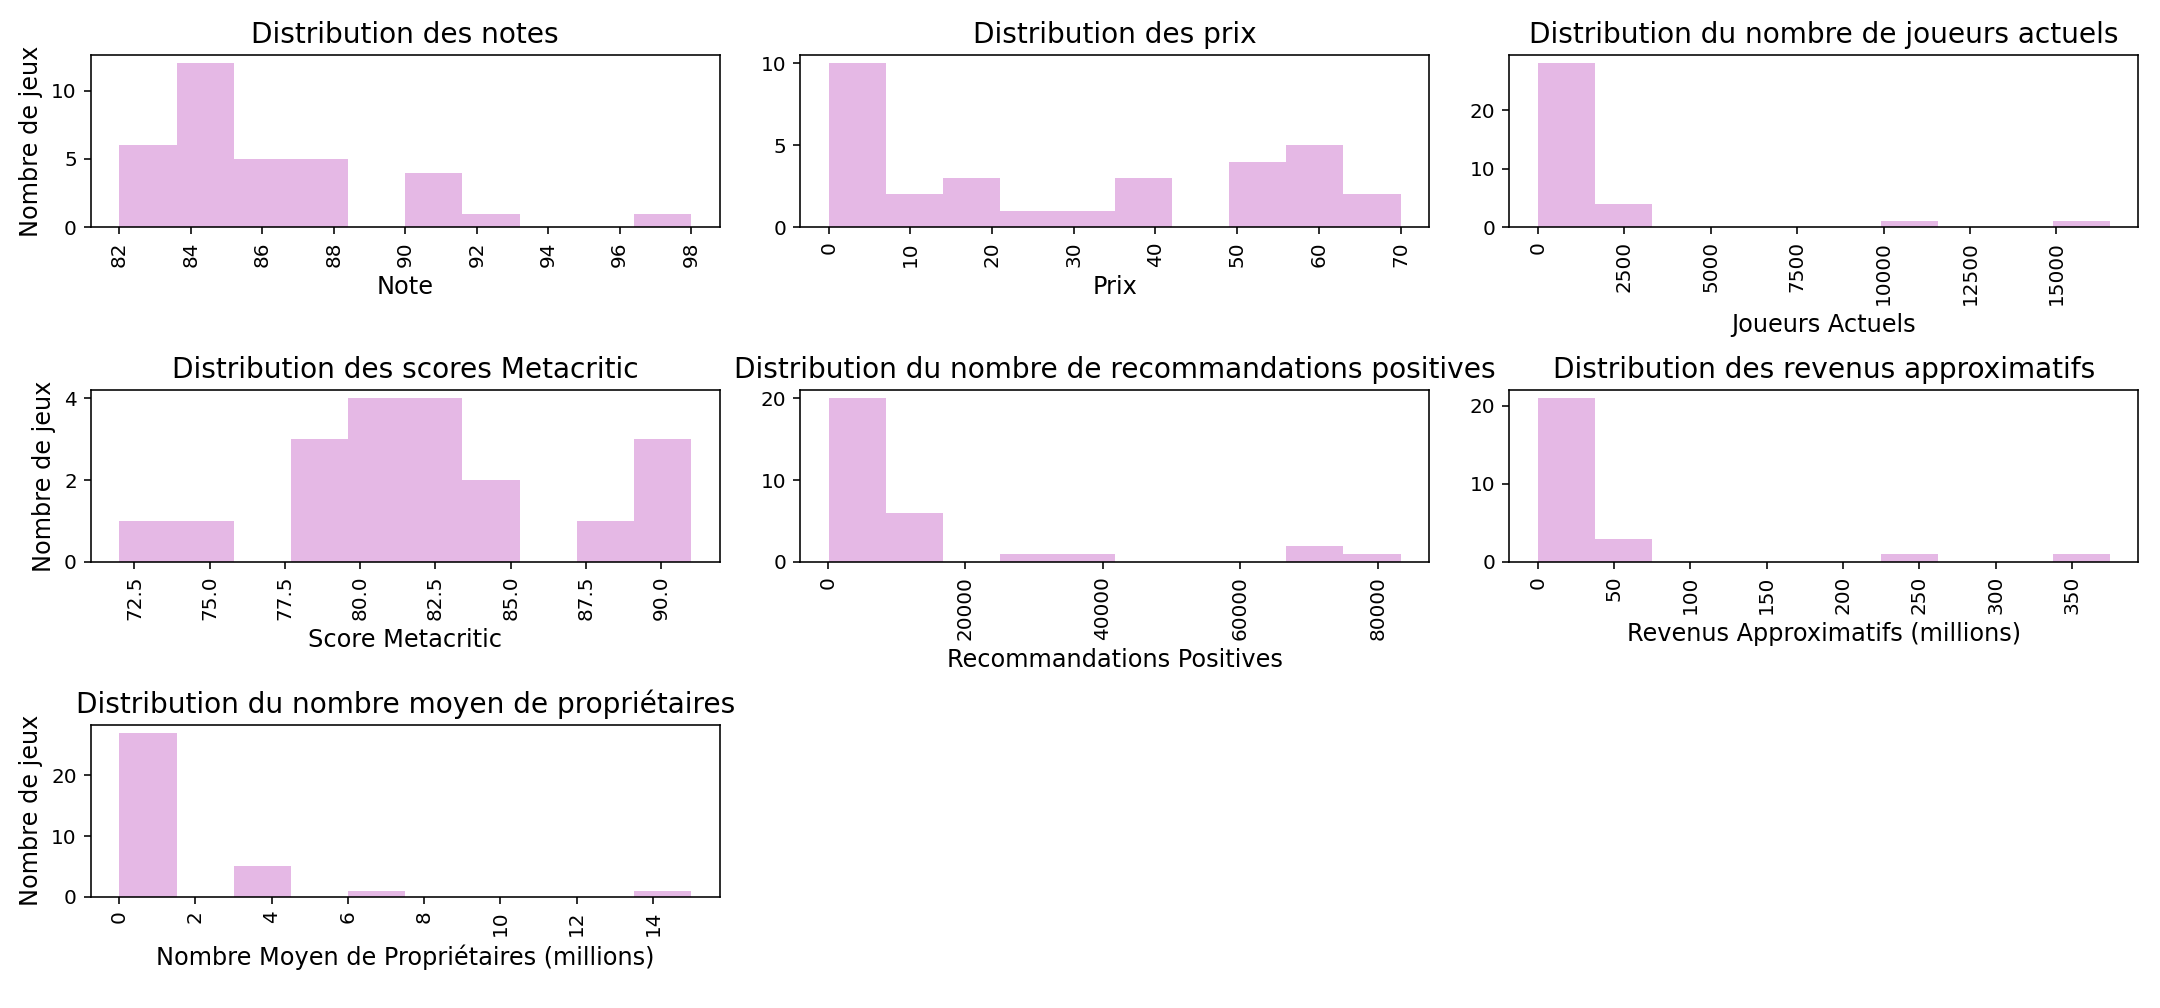

In [82]:
# Histogrammes interactifs de la distribution des variables continues

# Liste des colonnes pour lesquelles on veut générer des histogrammes
columns = ['Note', 'Prix', 'Joueurs Actuels', 'Score Metacritic', 'Recommandations Positives', 'Revenus Approximatifs (millions)', 'Nombre Moyen de Propriétaires (millions)']

def plot_all_histograms(bins):
    fig, axes = plt.subplots(3, 3, figsize=(15, 7))
    axes = axes.flatten()
    axes[7].set_visible(False) # Masque le huitième panneau (vide)
    axes[8].set_visible(False) # Masque le neuvième panneau (vide)

    for i, col in enumerate(columns):
        sns.histplot(df_withoutResume, x=col, bins=int(bins), color='plum', ax=axes[i], linewidth=0)
        axes[i].set_xlabel(col, fontsize=12)
            
        # Boucle pour ne pas afficher le label de l'axe y pour les graphiques 2, 3, 5 et 6 (indices 1, 2, 4, 5)
        if i in [1, 2, 4, 5]:
            axes[i].set_ylabel('', fontsize=12)
        else:
            axes[i].set_ylabel('Nombre de jeux', fontsize=12)
        axes[i].tick_params(axis='x', rotation=90)

    axes[0].set_title(f"Distribution des notes", fontsize=14)
    axes[1].set_title(f"Distribution des prix", fontsize=14)
    axes[2].set_title(f"Distribution du nombre de joueurs actuels", fontsize=14)
    axes[3].set_title(f"Distribution des scores Metacritic", fontsize=14)
    axes[4].set_title(f"Distribution du nombre de recommandations positives", fontsize=14)
    axes[5].set_title(f"Distribution des revenus approximatifs", fontsize=14)
    axes[6].set_title(f"Distribution du nombre moyen de propriétaires", fontsize=14)

    fig.tight_layout()
    plt.close(fig)  # Empêche l'affichage des figures supplémentaires (sinon duplication des figures liée à l'usage du curseur)
    return fig

# Création du curseur pour le nombre de bins
bins_slider = pn.widgets.IntSlider(name='Nombre de bins', start=3, end=34, step=1, value=10) # End à 34 car 34 jeux étudiés

# Génération des graphiques interactifs
interactive_plot = pn.bind(plot_all_histograms, bins=bins_slider)

# Affichage des widgets et graphiques
pn.Column(bins_slider, interactive_plot, sizing_mode='stretch_both').servable()

## Analyses descriptives

Ici, je répondrais aux questions : 
- Quelle est la corrélation entre les notes IGDB et les scores Metacritic ? *Pour rappel, la note IGDB et le score Metacritic confèrent tous deux à un avis d'experts.*
- Comment les prix évoluent-ils en fonction de la date de sortie, des plateformes et des modes de jeu ?  

### Corrélation entre les notes IGDB et les scores Metacritic

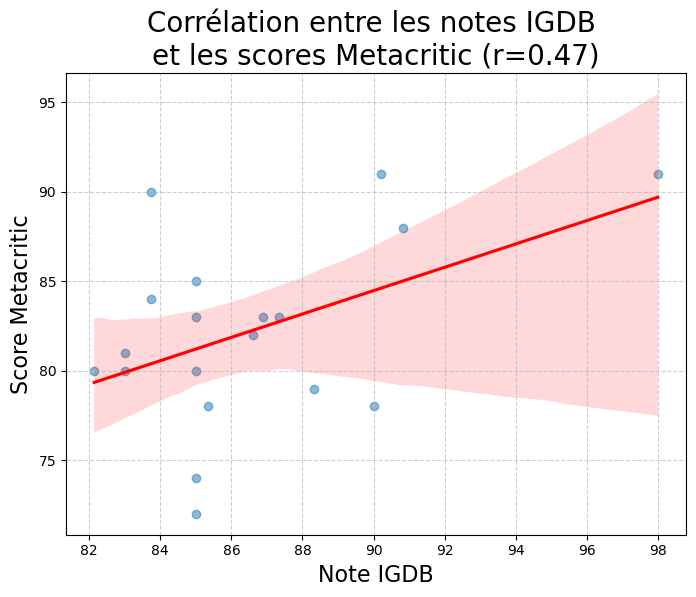

Coefficient de corrélation de Pearson : 0.47
P-value : 0.04427


In [83]:
# Suppression des valeurs NaN
df_clean = df_withoutResume[['Note', 'Score Metacritic']].dropna()

# Création d'un scatter plot
plt.figure(figsize=(8,6))
sns.regplot(x=df_clean['Note'], y=df_clean['Score Metacritic'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Calcul de la corrélation
corr_coeff, p_value = stats.pearsonr(df_clean['Note'], df_clean['Score Metacritic'])

# Tracé du graphique
plt.title(f'Corrélation entre les notes IGDB \net les scores Metacritic (r={corr_coeff:.2f})', fontsize=20)
plt.xlabel('Note IGDB', fontsize=16)
plt.ylabel('Score Metacritic', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Affichage des résultats numériques
print(f'Coefficient de corrélation de Pearson : {corr_coeff:.2f}')
print(f'P-value : {p_value:.5f}')

Le coefficient de corrélation de Pearson r de 0.47 indique une **corrélation modérée positive** entre les notes IGDB et les scores Metacritic, ce qui peut sembler étonnament bas puisque ces systèmes de notation sont tous deux basés sur des avis d'experts. Ceci s'explique par le fait qu'ils n'utilisent pas exactement les mêmes sources et appliquent une pondération différente selon les sources ; en outre, Metacritic a tendance à avoir une représentation plus importante de critiques nord-américaines, tandis qu'IGDB a une meilleure représentation internationale ou européenne.  
La p-value d'environ 0.044 est faible (< 0.05), ce qui signifie que la corrélation observée est **statistiquement significative** : il est très peu probable que cette relation soit due au hasard.  

### Corrélation entre les prix et les dates de sortie, les plateformes et les modes de jeu

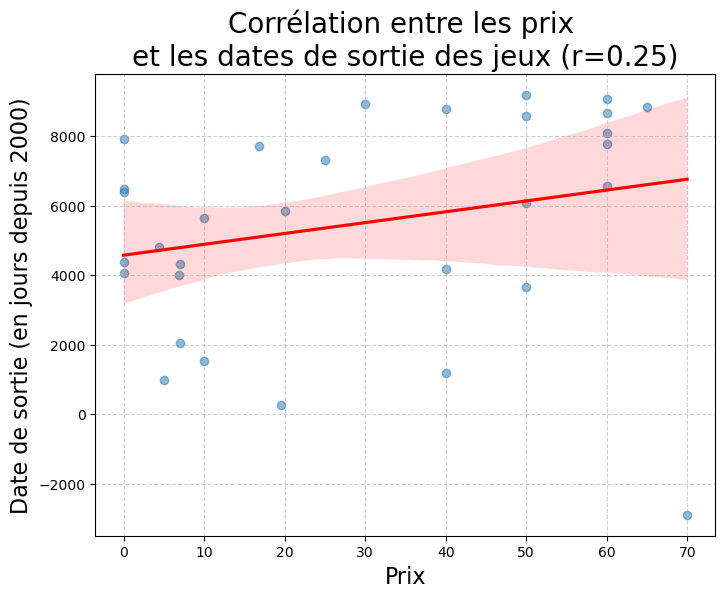

Coefficient de corrélation de Pearson : 0.25
P-value : 0.18142


In [84]:
## Corrélation entre les prix et les dates de sortie
# Conversion des dates en nombre de jours depuis le 1er janvier 2000 (pour pouvoir être géré par Pearson)
df_withoutResume['Date de sortie numérique'] = (df_withoutResume['Date de sortie'] - pd.Timestamp('2000-01-01')).dt.days

# Suppression des valeurs NaN
df_clean = df_withoutResume[['Prix', 'Date de sortie numérique']].dropna()

# Création du scatter plot
plt.figure(figsize=(8,6))
sns.regplot(x=df_clean['Prix'], y=df_clean['Date de sortie numérique'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Calcul de la corrélation
corr_coeff, p_value = stats.pearsonr(df_clean['Prix'], df_clean['Date de sortie numérique'])

# Tracé du graphique
plt.title(f'Corrélation entre les prix \net les dates de sortie des jeux (r={corr_coeff:.2f})', fontsize=20)
plt.xlabel('Prix', fontsize=16)
plt.ylabel('Date de sortie (en jours depuis 2000)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Affichage des résultats numériques
print(f'Coefficient de corrélation de Pearson : {corr_coeff:.2f}')
print(f'P-value : {p_value:.5f}')

Le coefficient de Pearson r de 0.25 indique une **très faible corrélation positive** entre le prix des jeux et leur date de sortie. La p-value d'environ 0.181 est largement supérieure à 0.05, ce qui signifie que cette corrélation **n'est pas statistiquement significative** : on ne peut donc pas affirmer avec confiance qu'il existe une relation entre ces deux variables.

Les prix des jeux ne sont pas uniquement liés à leur date de sortie mais aussi à d'autres éléments (popularité, studio, plateforme, promotions, etc.).
Les anciens jeux peuvent être vendus à prix élevé s’ils sont rares ou cultes.
Les promotions et variations de prix dans le temps peuvent également altérer la corrélation.

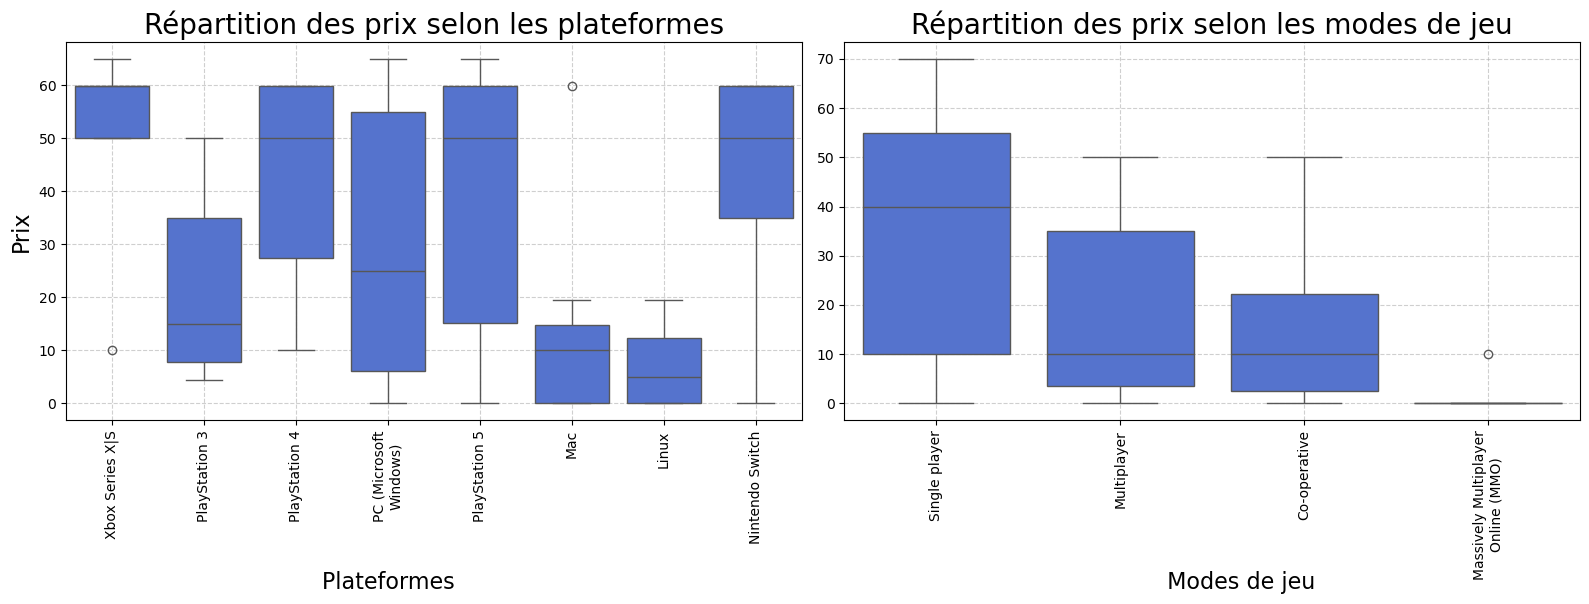

In [85]:
# Préparation des données pour les plateformes
df_withoutResume['Plateformes'] = df_withoutResume['Plateformes'].str.split(', ')
df_plateformes = df_withoutResume.explode('Plateformes')

# Réinitialisation de l'index pour éviter les doublons
df_plateformes = df_plateformes.reset_index(drop=True)

# Vérification du nombre de jeux par plateforme
platform_counts = df_plateformes['Plateformes'].value_counts()

# Je ne garde que les plateformes avec au moins 4 jeux
min_games = 4
valid_platforms = platform_counts[platform_counts >= min_games].index
df_filtered_platforms = df_plateformes[df_plateformes['Plateformes'].isin(valid_platforms)]

# Préparation des données pour les modes de jeu (même procédure)
df_withoutResume['Modes de jeu'] = df_withoutResume['Modes de jeu'].str.split(', ')
df_modes = df_withoutResume.explode('Modes de jeu')
df_modes = df_modes.reset_index(drop=True)
mode_counts = df_modes['Modes de jeu'].value_counts()
valid_modes = mode_counts[mode_counts >= min_games].index # Je ne garde que les modes de jeu avec au moins 4 jeux
df_filtered_modes = df_modes[df_modes['Modes de jeu'].isin(valid_modes)]

# Liste des colonnes à explorer
categories = ['Plateformes', 'Modes de jeu']
data_frames = [df_filtered_platforms, df_filtered_modes]
titles = ['Répartition des prix selon les plateformes', 'Répartition des prix selon les modes de jeu']

# Création des subplots pour afficher les deux boxplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boucle pour créer les boxplots
for i, category in enumerate(categories):
    sns.boxplot(x=data_frames[i][category], y=data_frames[i]['Prix'], color='royalblue', ax=axes[i])
    
    # Appliquer la fonction pour couper les étiquettes longues
    new_index = [split_label(str(label)) for label in data_frames[i][category].unique()] # Utilisation de la fonction split_label définie précédemment pour couper les étiquettes longues en deux lignes
    axes[i].set_xticks(range(len(new_index)))
    axes[i].set_xticklabels(new_index)
    
    axes[i].set_title(titles[i], fontsize=20)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prix', fontsize=16)
    axes[i].tick_params(axis="x", rotation=90)
    axes[i].grid(True, linestyle="--", alpha=0.6)

axes[1].set_ylabel('')  # Supprime le libellé de l'axe des y du second graphique

fig.text(0.515, 0.01, 'Plateformes                                                                                                    Modes de jeu', 
         ha='center', fontsize=16) # Aligne les libellés de l'axe des x 

# Affichage des plots
plt.tight_layout()
plt.show()

In [86]:
# ANOVA pour tester si les moyennes des prix sont significativement différentes entre plateformes et entre modes de jeu

# Création des groupes de prix pour chaque plateforme
groupes_platform = [
    df_filtered_platforms[df_filtered_platforms['Plateformes'] == plateform]['Prix'].dropna()
    for plateform in df_filtered_platforms['Plateformes'].unique()
]

f_stat, p_value = stats.f_oneway(*groupes_platform)

print("ANOVA pour les différences entre plateformes :")
print(f"F-statistique : {f_stat:.2f}")
print(f"P-value : {p_value:.5f}")

# Création des groupes de prix pour chaque mode de jeu
groupes_mode = [
    df_filtered_modes[df_filtered_modes['Modes de jeu'] == mode]['Prix'].dropna()
    for mode in df_filtered_modes['Modes de jeu'].unique()
]

f_stat, p_value = stats.f_oneway(*groupes_gamemode)

print("")
print("ANOVA pour les différences entre modes de jeu :")
print(f"F-statistique : {f_stat:.2f}")
print(f"P-value : {p_value:.5f}")

ANOVA pour les différences entre plateformes :
F-statistique : 2.45
P-value : 0.02802

ANOVA pour les différences entre modes de jeu :
F-statistique : 4.42
P-value : 0.00820


Qu'il s'agisse des différences entre plateformes ou entre modes de jeu, la **F-statistique** est supérieure à 1, ce qui signifie que la variabilité *entre* les groupes (différences de prix entre plateformes/modes de jeu) est plus élevée que la variabilité *au sein* des groupes (différences de prix entre jeux d'une même plateforme/mode de jeu).  
La valeur de la F-statistique en tant que telle ne renseigne pas sur le caractère significatif de ces différences ; l'hypothèse nulle est rejetée à partir d'une valeur seuil spécifique qui dépend des degrés de liberté (calculés à partir du nombre de groupes et d'observations).  
La détermination de la **p-value** se base sur cette valeur. Ici, les **p-values** inférieures à 0.05 pour les plateformes comme pour les modes de jeu montrent qu'il existe des différences statistiquement significatives entre les prix des jeux en fonction de ces deux variables (attention, cela signifie simplement qu'au moins ***une*** plateforme/***un*** mode de jeu se distingue).

Le **test de comparaison post-hoc de Tukey** nous permet de comparer toutes les paires de groupes (plateformes et modes de jeu) afin de déterminer quelles différences spécifiques sont significatives (voir ci-après).

In [87]:
# Test de Tukey pour les différences entre plateformes
df_filtered_platforms = df_filtered_platforms.dropna(subset=['Prix', 'Plateformes'])

tukey_result_platforms = pairwise_tukeyhsd(endog=df_filtered_platforms['Prix'], 
                                 groups=df_filtered_platforms['Plateformes'], 
                                 alpha=0.05)

# Affichage du résumé sous forme de tableau
tukey_result_platforms.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Linux,Mac,6.8375,0.9997,-38.1223,51.7973,False
Linux,Nintendo Switch,35.4761,0.2249,-9.4837,80.4359,False
Linux,PC (Microsoft Windows),21.6853,0.6536,-17.174,60.5446,False
Linux,PlayStation 3,14.5142,0.975,-31.788,60.8163,False
Linux,PlayStation 4,35.1175,0.211,-8.8086,79.0436,False
Linux,PlayStation 5,31.5938,0.3332,-12.3323,75.5198,False
Linux,Xbox Series X|S,41.6175,0.1378,-6.5011,89.7361,False
Mac,Nintendo Switch,28.6386,0.2871,-9.7033,66.9804,False
Mac,PC (Microsoft Windows),14.8478,0.8013,-16.116,45.8117,False
Mac,PlayStation 3,7.6767,0.9987,-32.2308,47.5841,False


Ici, surprise... le test de Tukey ne trouve aucune différence significative entre les paires individuelles. Il semblerait que nous soyons face au *"paradoxe ANOVA-Tukey"*.   
Cette situation n'est pas nécessairement une erreur statistique, mais plutôt une limite de la méthodologie qui suggère que **les différences entre plateformes existent mais sont subtiles**. Elle peut être causée par différents facteurs, et notamment par la différence de puissance statistique entre l'ANOVA - qui teste l'hypothèse nulle sur la base de toutes les données simultanément - et le test de Tukey - qui teste chaque paire individuellement. Certains groupes (plateformes) ont d'ailleurs un très petit nombre d'observations, ce qui peut réduire la puissance du test de Tukey.  
En outre, le test de Tukey utilise une correction pour les comparaisons multiples qui rend le seuil de signification plus strict pour chaque comparaison individuelle. Cette correction peut conduire à ce qu'aucune comparaison individuelle n'atteigne le seuil de signification, même si l'effet global est significatif.  

In [13]:
# Test de Tukey pour les différences entre modes de jeu
df_filtered_modes = df_filtered_modes.dropna(subset=['Prix', 'Modes de jeu'])

tukey_result_modes = pairwise_tukeyhsd(endog=df_filtered_modes['Prix'], 
                                 groups=df_filtered_modes['Modes de jeu'], 
                                 alpha=0.05)

# Affichage du résumé sous forme de tableau
tukey_result_modes.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Co-operative,Massively Multiplayer Online (MMO),-13.6391,0.6754,-45.9175,18.6392,False
Co-operative,Multiplayer,4.5374,0.9686,-22.1156,31.1904,False
Co-operative,Single player,18.301,0.1728,-5.08,41.682,False
Massively Multiplayer Online (MMO),Multiplayer,18.1765,0.3726,-11.5561,47.9092,False
Massively Multiplayer Online (MMO),Single player,31.9401,0.0139,5.1013,58.779,True
Multiplayer,Single player,13.7636,0.2591,-5.9547,33.4819,False


Le test de Tukey révèle qu'il existe une **différence significative entre les prix des jeux MMO et des jeux Single player** (p-value < 0.05, à l'origine du résultat significatif de l'ANOVA), mais pas entre les autres modes de jeu (pour lesquels p-value > 0.05).  
Le **prix des MMO est plus élevé que celui des jeux Single player**, avec une différence moyenne de prix de 31.94 €.


## Analyses prédictives

Je construis dans cette partie une série de **modèles linéaires** afin d'*évaluer* l'effet **de l'année de sortie, de la note, du prix et du nombre de recommandations positives d'un jeu** sur **le nombre de joueurs actuels**, et afin de *prédire* ce nombre-là.

### Exploration graphique  
Afin d'explorer les relations entre ma variable cible et mes variables catégorielles pour juger de la pertinence de les intégrer dans un modèle linéaire, je réalise des diagrammes en violon pour chacune d'elles.   
**Interprétation :**  
- Si les diagrammes en violon laissent apparaître des écarts importants entre les catégories de la variable *(p. ex. : certaines notes associées à bien plus de joueurs actuels)*, la variable est potentiellement informative pour le modèle.  
- A l'inverse, si toutes les catégories ont des valeurs similaires, ou que la distribution est très bruitée, alors la variable n’apporte peut-être pas d’information pertinente.

In [31]:
# En prévision de la création de bins pour chacune de mes variables catégorielles, je coupe en 6 bins de taille égale chaque variable
print(pd.qcut(df_withoutResume['Note'], q=5).unique()) # Ici, je m'arrête à 5 bins car à partir de 6, j'obtiens une duplication avec la valeur 85.0 qui apparaît dans les limites de deux bins différents
print(pd.qcut(df_withoutResume['Prix'], q=5).unique()) # Ici, je m'arrête à 5 bins car à partir de 6, j'obtiens une duplication avec la valeur 0.0 qui apparaît dans les limites des deux premiers bins
print(pd.qcut(df_withoutResume['Année'], q=6).unique())
print(pd.qcut(df_withoutResume['Recommandations Positives'], q=6).unique())

[(85.74, 87.832], (83.75, 85.0], (81.999, 83.75], (85.0, 85.74], (87.832, 98.0]]
Categories (5, interval[float64, right]): [(81.999, 83.75] < (83.75, 85.0] < (85.0, 85.74] < (85.74, 87.832] < (87.832, 98.0]]
[(4.99, 16.79], (-0.001, 4.99], (16.79, 39.99], (39.99, 59.99], (59.99, 69.99], NaN]
Categories (5, interval[float64, right]): [(-0.001, 4.99] < (4.99, 16.79] < (16.79, 39.99] < (39.99, 59.99] < (59.99, 69.99]]
[(2011.0, 2016.0], (2016.0, 2019.0], (2007.0, 2011.0], (2019.0, 2023.0], (2023.0, 2025.0], (1991.999, 2007.0]]
Categories (6, interval[float64, right]): [(1991.999, 2007.0] < (2007.0, 2011.0] < (2011.0, 2016.0] < (2016.0, 2019.0] < (2019.0, 2023.0] < (2023.0, 2025.0]]
[(15263.0, 83299.0], (1575.0, 3096.0], (129.999, 632.0], (3096.0, 8690.0], (632.0, 1575.0], (8690.0, 15263.0], NaN]
Categories (6, interval[float64, right]): [(129.999, 632.0] < (632.0, 1575.0] < (1575.0, 3096.0] < (3096.0, 8690.0] < (8690.0, 15263.0] < (15263.0, 83299.0]]


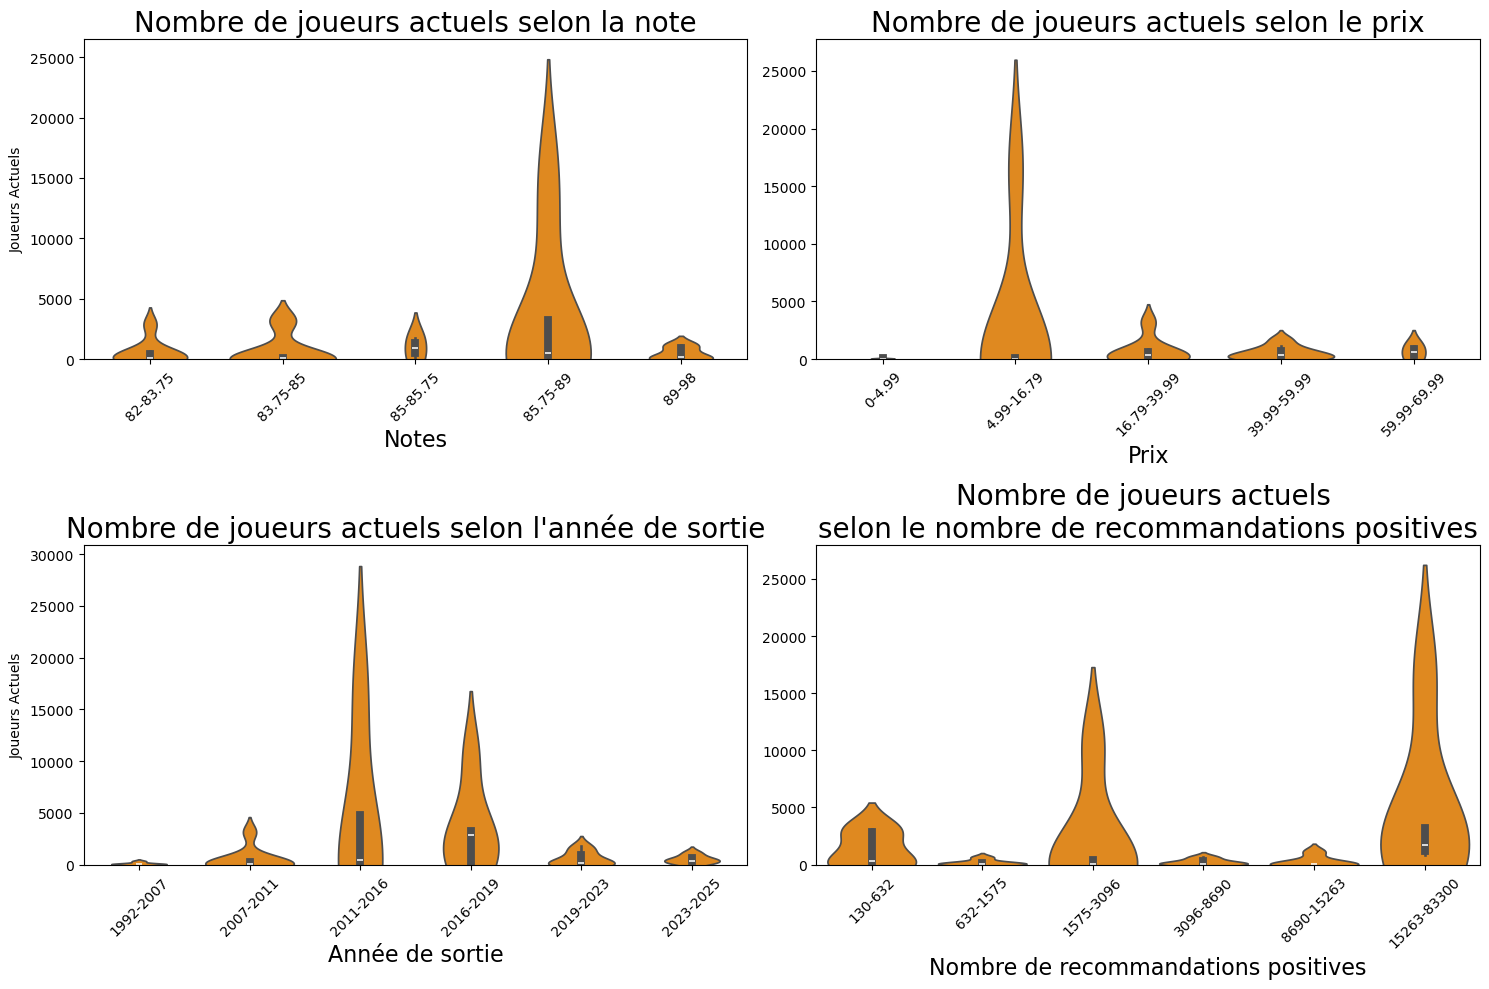

In [34]:
cat_vars = ['Note', 'Prix', 'Année', 'Recommandations Positives']

# Création de bins de taille à peu près égale pour chaque variable catégorielle
# Note
bins_note = [82, 83.75, 85, 85.75, 89, 98]
labels_note = ['82-83.75', '83.75-85', '85-85.75', '85.75-89', '89-98']
df_withoutResume['Note_binned'] = pd.cut(df_withoutResume['Note'], bins=bins_note, labels=labels_note)

# Prix 
bins_prix = [0, 4.99, 16.79, 39.99, 59.99, 69.99]
labels_prix = ['0-4.99', '4.99-16.79', '16.79-39.99', '39.99-59.99', '59.99-69.99']
df_withoutResume['Prix_binned'] = pd.cut(df_withoutResume['Prix'], bins=bins_prix, labels=labels_prix)

# Année de sortie
bins_annee = [1992, 2007, 2011, 2016, 2019, 2023, 2025]
labels_annee = ['1992-2007', '2007-2011', '2011-2016', '2016-2019', '2019-2023', '2023-2025']
df_withoutResume['Annee_binned'] = pd.cut(df_withoutResume['Année'], bins=bins_annee, labels=labels_annee)

# Recommandations Positives
bins_rec = [130, 632, 1575, 3096, 8690, 15263, 83300]
labels_rec = ['130-632', '632-1575', '1575-3096', '3096-8690', '8690-15263', '15263-83300']
df_withoutResume['Recommandations_binned'] = pd.cut(df_withoutResume['Recommandations Positives'], bins=bins_rec, labels=labels_rec)

# Création des violon plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Violon plot pour 'Note'
sns.violinplot(x='Note_binned', y='Joueurs Actuels', data=df_withoutResume, ax=axes[0, 0], density_norm='count', color='darkorange')
axes[0, 0].set_title("Nombre de joueurs actuels selon la note", fontsize=20)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_xlabel("Notes", fontsize=16)

# Violon plot pour 'Prix'
sns.violinplot(x='Prix_binned', y='Joueurs Actuels', data=df_withoutResume, ax=axes[0, 1], density_norm='count', color='darkorange')
axes[0, 1].set_title("Nombre de joueurs actuels selon le prix", fontsize=20)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("Prix", fontsize=16)

# Violon plot pour 'Année'
sns.violinplot(x='Annee_binned', y='Joueurs Actuels', data=df_withoutResume, ax=axes[1, 0], density_norm='count', color='darkorange')
axes[1, 0].set_title("Nombre de joueurs actuels selon l'année de sortie", fontsize=20)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xlabel("Année de sortie", fontsize=16)

# Violon plot pour 'Recommandations Positives'
sns.violinplot(x='Recommandations_binned', y='Joueurs Actuels', data=df_withoutResume, ax=axes[1, 1], density_norm='count', color='darkorange')
axes[1, 1].set_title("Nombre de joueurs actuels \nselon le nombre de recommandations positives", fontsize=20)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("Nombre de recommandations positives", fontsize=16)

# Limite inférieure à 0 pour l'axe des ordonnées de chaque plot (car il ne peut pas y avoir un nombre négatif de joueurs actuels)
for ax in axes.flatten():
    ax.set_ylim(bottom=0) # Conseil : faites varier la limite supérieure pour mieux visualiser les violons les plus bas, p.ex. : ax.set_ylim(bottom=0, top=3000)

plt.tight_layout()
plt.show()

Les violons sont tronqués à zéro car le nombre de joueurs actuels ne peut pas être négatif.  
Cette solution, bien qu'esthétiquement discutable, n'altère pas la distribution originale des données comme le ferait une transformation logarithmique.

Les représentations sont extrêmement tirées par les valeurs extrêmes de joueurs actuels (dont 16543 pour *Final Fantasy XIV: Heavensward*). N'hésitez pas à ajouter une limite à l'axe des y pour modifier la granularité (p.ex. à 3000, voir commentaire dans le code).

### Recherche de corrélations entre les variables catégorielles  
Si deux variables sont fortement corrélées, elles expliquent en grande partie la même information. Cela peut perturber la construction d'un modèle linéaire, qui aura du mal à distinguer l'effet propre de chaque variable, ce qui peut entraîner des coefficients instables, voire contre-intuitifs. Pour diagnostiquer la multicolinéarité avant de modéliser, je réalise une exploration graphique sous forme de *heatmap*, basée sur le **coefficient de corrélation de Pearson**. Cette statistique évalue la **force** de la relation linéaire entre deux variables quantitatives continues. Un coefficient de corrélation supérieur à 0.8 ou inférieur à -0.8 indique un risque élevé de colinéarité, respectivement positive ou négative.

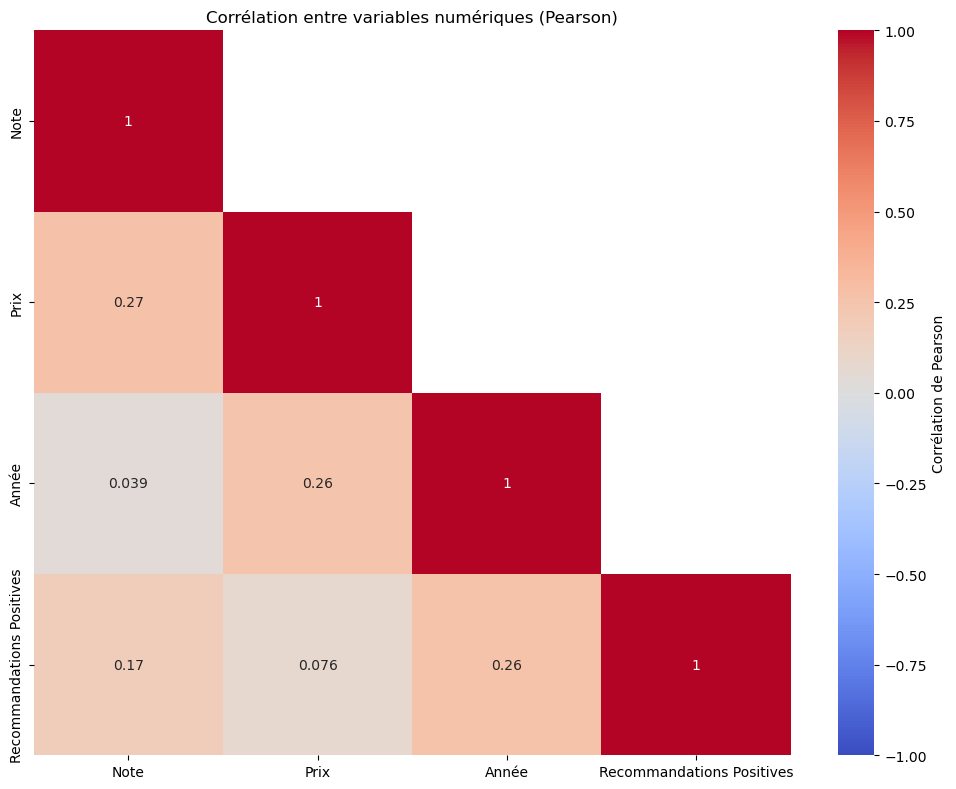

In [35]:
def numerical_correlation_matrix(df, numerical_columns):
    return df[numerical_columns].corr(method='pearson')

num_vars = ['Note', 'Prix', 'Année', 'Recommandations Positives']  

correlation_matrix = numerical_correlation_matrix(df_withoutResume, num_vars)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            mask=np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1),
            cbar_kws={'label': 'Corrélation de Pearson'})
plt.title('Corrélation entre variables numériques (Pearson)')
plt.tight_layout()
plt.show()

Les quatre variables catégorielles considérées ne sont pas redondantes. 

### Modèle linéaire (*statsmodels* et *sklearn*)

Pour tester l'effet des variables catégorielles 'Prix', 'Note', 'Recommandations positives' et 'Année' sur le nombre de joueurs actuels, j'utilise **deux approches** non mutuellement exclusives : 
- Une approche via *statsmodels* qui permet de **comprendre et d'interpréter l'effet de chaque variable** :
  - Cette approche fournit des statistiques détaillées (p-values, intervalles de confiance et R² ajustés) ;
  - Permet d'interpréter facilement la significativité statistique de chaque variable ;
  - Offre des diagnostics de régression complets.   
- Une approche via *sklearn* avec train/test split dont l'objectif est la **prédiction** précise du nombre de joueurs :
  - Cette approche permet notamment d'évaluer la capacité de généralisation du modèle sur de nouvelles données ;
  - Evite le surapprentissage.

#### Approche 1 via *statsmodels* : approche statistique
**Combinatorial feature selection :**
Je teste ici différents modèles linéaires avec/sans chacune des variables catégorielles afin de mesurer la contribution individuelle de chaque variable au **pouvoir explicatif** du modèle (et donc identifier les variables qui ont peu ou pas d'impact).  
Je compare alors les métriques R², R² ajusté, AIC et BIC entre les modèles pour voir comment la performance change quand une variable est ôtée. 

In [41]:
# Préparation des données (gestion des NaN de 'Prix' et de 'Recommandations Positives', et du type de 'Recommandations Positives')
df_withoutResume['Prix'] = df_withoutResume['Prix'].fillna(df_withoutResume['Prix'].median()) # Remplacement des NaN par la médiane pour préserver un maximum de données
df_withoutResume['Recommandations Positives'] = df_withoutResume['Recommandations Positives'].fillna(df_withoutResume['Recommandations Positives'].median()) # Remplacement des NaN par la médiane pour préserver un maximum de données
df_withoutResume['Recommandations Positives'] = df_withoutResume['Recommandations Positives'].astype('float64')

# Fonction pour tester les différents modèles avec/sans chacune des variables
def test_all_combinations_no_formula(df, cat_vars, dependent_var):
    results = {}
    
    for r in range(1, len(cat_vars) + 1): # itère sur des nombres de 1 jusqu'au nombre total de variables de cat_vars
        for vars_combo in combinations(cat_vars, r): # génère toutes les combinaisons possibles de r variables parmi l'ensemble cat_vars
            try:
                X = df[list(vars_combo)].copy() # .copy() évite les problèmes de vue/copie de pandas
                y = df[dependent_var]
                
                # Ajout d'une constante pour l'intercept du modèle (non inclus par défaut par statsmodels)
                X = sm.add_constant(X) 
                
                # Ajustement du modèle
                model = sm.OLS(y, X).fit()
                
                # Stockage des résultats
                model_name = " + ".join(vars_combo)
                results[model_name] = {
                    'r_squared': model.rsquared,
                    'adj_r_squared': model.rsquared_adj,
                    'aic': model.aic,
                    'bic': model.bic,
                    'model': model,
                    'variables': vars_combo
                }
                # print(f"Modèle ajusté avec succès: {model_name}")
            except Exception as e:
                print(f"Erreur avec les variables: {vars_combo}")
                print(f"Message d'erreur: {str(e)}")
                continue
    
    return results

# Application à notre dataframe
cat_vars = ['Note', 'Prix', 'Année', 'Recommandations Positives']
dependent_var = 'Joueurs Actuels'

models_results = test_all_combinations_no_formula(df_withoutResume, cat_vars, dependent_var)

# Création d'un dataframe résumant les résultats
def create_summary(results):
    if not results:
        print("Aucun modèle n'a pu être ajusté correctement.")
        return None
        
    summary_df = pd.DataFrame({
        'model': list(results.keys()),
        'r_squared': [res['r_squared'] for res in results.values()],
        'adj_r_squared': [res['adj_r_squared'] for res in results.values()],
        'aic': [res['aic'] for res in results.values()],
        'bic': [res['bic'] for res in results.values()]
    })
    
    # Tri par AIC croissant
    summary_df = summary_df.sort_values('aic')
    return summary_df

summary = create_summary(models_results)
if summary is not None:
    print("\nRésumé des modèles (trié par AIC croissant):")
    display(summary)

    # Affichage du meilleur modèle selon AIC
    best_model_name = summary.iloc[0]['model']
    best_model = models_results[best_model_name]['model']
    print("\nMeilleur modèle selon AIC:")
    print(best_model.summary())


Résumé des modèles (trié par AIC croissant):


,model,r_squared,adj_r_squared,aic,bic
8,Prix + Recommandations Positives,0.344211,0.301902,638.298907,642.877988
13,Prix + Année + Recommandations Positives,0.349178,0.284095,640.040453,646.145895
11,Note + Prix + Recommandations Positives,0.344664,0.279131,640.275418,646.380860
3,Recommandations Positives,0.240684,0.216955,641.282608,644.335329
14,Note + Prix + Année + Recommandations Positives,0.349777,0.260091,642.009126,649.640928
6,Note + Recommandations Positives,0.241522,0.192588,643.245060,647.824141
9,Année + Recommandations Positives,0.240756,0.191773,643.279383,647.858464
12,Note + Année + Recommandations Positives,0.241597,0.165757,645.241695,651.347137
1,Prix,0.069359,0.040276,648.200113,651.252834
7,Prix + Année,0.102202,0.044280,648.978521,653.557603



Meilleur modèle selon AIC:
                            OLS Regression Results                            
Dep. Variable:        Joueurs Actuels   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     8.136
Date:                Wed, 16 Apr 2025   Prob (F-statistic):            0.00144
Time:                        09:01:38   Log-Likelihood:                -316.15
No. Observations:                  34   AIC:                             638.3
Df Residuals:                      31   BIC:                             642.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

Le **R² (coefficient de détermination)** et le **R² ajusté** sont des indicateurs de la qualité de l'*ajustement* d’un modèle aux données. Le R² ajusté pénalise les modèles trop complexes (i.e. avec trop de variables explicatives), ce qui en fait un critère plus pertinent que le R² simple pour comparer des modèles avec un nombre différent de variables.  
Ici, l’ajout de la variable **'Recommandations Positives'** améliore significativement la capacité explicative des modèles concernant le nombre de joueurs actuels.  
En sciences de consommation, un R² ou R² ajsuté de 0,3-0,6 est souvent jugé comme satisfaisant ; dans notre cas, pour le nombre de joueurs actuels d'un jeu qui est influencé par de nombreux facteurs dont certains difficiles à quantifier comme la qualité du gameplay, le bouche-à-oreille, les tendances actuelles, un R² ajusté de 0,3-0,4 est intéressant.  
Le modèle **'Prix' + 'Recommandations Positives'** présente le meilleur R² ajusté.  

Les **critères AIC (Critère d’Information d’Akaike)** et **BIC (Critère d’Information Bayésien)** évaluent également la qualité d’un modèle, en cherchant un *équilibre* entre *ajustement* aux données et *complexité* du modèle. Le BIC applique une pénalisation plus forte pour les modèles complexes (i.e. avec davantage de paramètres). Dans les deux cas, une valeur plus faible indique un meilleur modèle. Ces critères n’ont pas d’échelle absolue et ne servent qu’à comparer différents modèles.  
Pour l’AIC, on considère généralement que deux modèles sont équivalents si leur différence est inférieure à 2. Ici encore, les différences d’AIC sont relativement marquées entre les modèles qui incluent ou non la variable **'Recommandations Positives'**. Les plus faibles valeurs sont obtenues pour des modèles qui incluent à la fois les **'Recommandations Positives'** et le **'Prix'**.  
Comme pour le R² ajusté, le meilleur modèle retenu par l'AIC **'Prix' + 'Recommandations Positives'**.  
Les mêmes tendances sont observées pour le BIC.	

#### Approche 2 via *sklearn* : approche machine learning
La démarche est la même que dans l'approche 1 (test de différents modèles linéaires avec/sans chacune des variables), mais la découpe entre deux échantillons train et test permet d'envisager ici la **prédiction** précise du nombre de joueurs.  
J'analyse ici la MAE et la RMSE dans l'optique de comprendre l'**ampleur des erreurs** directement dans l'unité de la variable cible.

*Attention :* En réalisant le split train/test, je n'ai que 7 observations dans le jeu de test, ce qui est **très** faible. L'approche 1 est plus pertinente sur le dataset étudié, mais j'ai souhaité travailler sur cette deuxième approche pour me familiariser avec.  
&#8594; **Cependant, ses résultats ne peuvent être tenus pour acquis.**  
En général, on se base plutôt sur le RMSE test que sur celui issu de la validation croisée pour comparer les modèles car le jeu de test représente des données que le modèle n'a jamais vues, ce qui simule mieux son comportement en production face à de nouvelles données. Ainsi, le RMSE test donne une estimation non biaisée de la performance sur des données futures, tandis que la validation croisée peut parfois être trop optimiste. Un unique RMSE test est aussi plus facile à comparer entre modèles qu'une distribution de valeurs issues de la validation croisée.  
Cela dit, la validation croisée présente aussi des avantages importants puisqu'elle utilise plus efficacement les données disponibles et réduit le risque de sur-ajustement au jeu de test.  
**Ici, avec 7 observations, le RMSE test et le MAE test ne sont pas du tout fiables, et il vaut mieux discuter des performances du modèle à partir des métriques de validation croisée**.


Résumé des modèles (trié par RMSE cv croissant):


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,mae_cv,rmse_cv
7,Prix + Année,0.105975,0.019386,1518.695635,2730.826883,2986.821263,3571.433755,1606.362262,3116.467619
2,Année,0.005097,0.002711,1567.039321,2055.723627,3150.827442,3601.671259,1590.320674,3125.040062
1,Prix,0.050835,0.102048,1567.140787,2217.438073,3077.549556,3417.591108,1636.472116,3169.949531
0,Note,0.000022,-0.020373,1594.345506,2122.282054,3158.854266,3643.116452,1689.301725,3191.418093
8,Prix + Recommandations Positives,0.444816,0.009666,1540.779602,2181.655759,2353.707982,3589.091877,1851.141342,3208.348317
13,Prix + Année + Recommandations Positives,0.454070,-0.001599,1512.803064,2398.763886,2334.009319,3609.446745,1839.571147,3215.357424
5,Note + Année,0.005198,0.006901,1570.226527,2048.823943,3150.667788,3594.097938,1746.382425,3229.899919
4,Note + Prix,0.053432,0.128744,1582.182565,2139.551925,3073.337751,3366.406961,1692.365872,3245.140420
11,Note + Prix + Recommandations Positives,0.448533,-0.025573,1516.381570,2275.712719,2345.816276,3652.388287,1866.327629,3260.163704
3,Recommandations Positives,0.368708,-0.181908,1268.621023,1745.378785,2509.859848,3920.897780,1589.623248,3312.491692



Meilleur modèle selon RMSE cv:
Variables: ('Prix', 'Année')
Coefficients: {'Prix': -56.47945394120502, 'Année': 117.31907291267744}
Intercept: -233453.178208723
R² (train): 0.1060
R² (test): 0.0194
MAE (train): 1518.6956
MAE (test): 2730.8269
RMSE (train): 2986.8213
RMSE (test): 3571.4338
MAE (CV): 1606.3623
RMSE (CV): 3116.4676


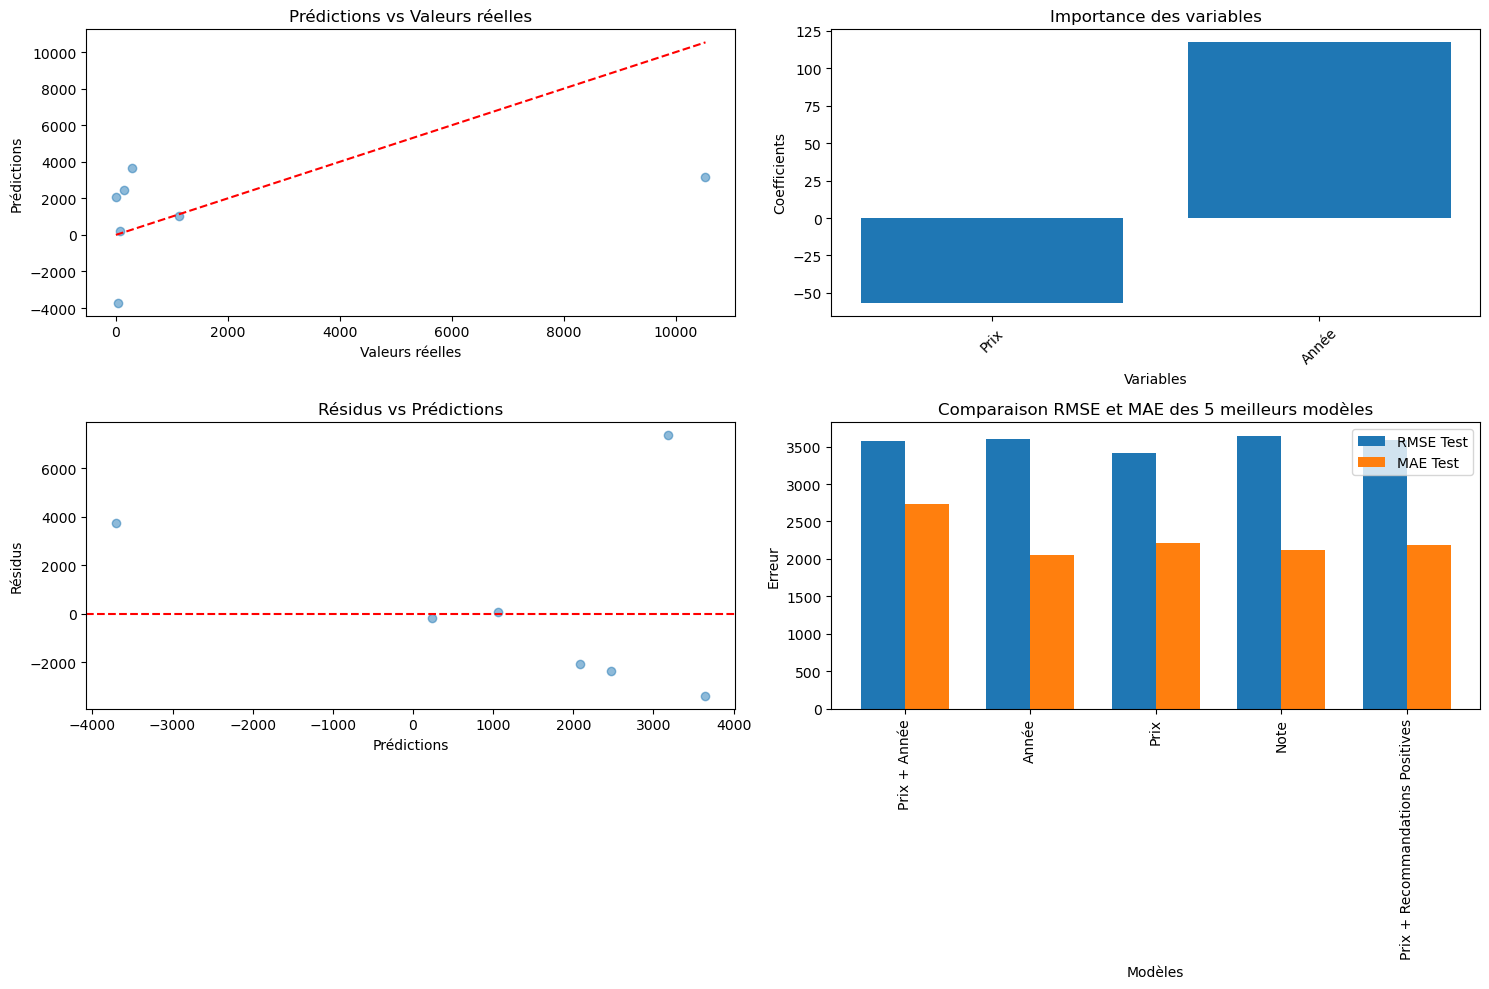

In [52]:
# Fonction pour tester les différentes combinaisons de variables avec train/test split
def test_all_combinations_sklearn(df, cat_vars, dependent_var, test_size=0.2, random_state=12):
    results = {}
    
    # Division en train/test avant l'itération pour éviter le data leakage
    # Si ceci n'est pas fait avant l'itération mais à l'intérieur de la boucle qui teste chaque combinaison, chaque modèle est évalué sur un ensemble de test différent (comparaison équitable entre les modèles rendue impossible) + des informations peuvent fuiter entre les différents tests
    X_full = df[cat_vars].copy()
    y_full = df[dependent_var].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=test_size, random_state=random_state)
    
    for r in range(1, len(cat_vars) + 1):
        for vars_combo in combinations(cat_vars, r):
            try:
                # Sélection des variables pour le modèle
                vars_list = list(vars_combo)
                X_train_subset = X_train[vars_list].copy()
                X_test_subset = X_test[vars_list].copy()
                
                # Création et entraînement du modèle
                model = LinearRegression()
                model.fit(X_train_subset, y_train)
                
                # Prédictions et évaluation sur train et test
                y_train_pred = model.predict(X_train_subset)
                y_test_pred = model.predict(X_test_subset)
                
                # Calcul des métriques
                r2_train = r2_score(y_train, y_train_pred)
                r2_test = r2_score(y_test, y_test_pred)
                
                # Calcul de MAE et RMSE pour les ensembles d'entraînement et de test
                mae_train = mean_absolute_error(y_train, y_train_pred)
                mae_test = mean_absolute_error(y_test, y_test_pred)
                rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
                rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
                
                # Validation croisée pour obtenir des métriques plus robustes
                cv_mae = -np.mean(cross_val_score(model, X_train_subset, y_train, cv=5, scoring='neg_mean_absolute_error'))
                cv_rmse = np.sqrt(-np.mean(cross_val_score(model, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error')))
                
                # Stockage des résultats
                model_name = " + ".join(vars_combo)
                results[model_name] = {
                    'r2_train': r2_train,
                    'r2_test': r2_test,
                    'mae_train': mae_train,
                    'mae_test': mae_test,
                    'rmse_train': rmse_train,
                    'rmse_test': rmse_test,
                    'mae_cv': cv_mae,
                    'rmse_cv': cv_rmse,
                    'model': model,
                    'variables': vars_combo,
                    'coefficients': dict(zip(vars_list, model.coef_)),
                    'intercept': model.intercept_
                }
                # print(f"Modèle ajusté avec succès: {model_name}")
            except Exception as e:
                print(f"Erreur avec les variables: {vars_combo}")
                print(f"Message d'erreur: {str(e)}")
                continue
    
    return results, X_train, X_test, y_train, y_test

# Application à notre dataframe
cat_vars = ['Note', 'Prix', 'Année', 'Recommandations Positives']
dependent_var = 'Joueurs Actuels'
models_results, X_train, X_test, y_train, y_test = test_all_combinations_sklearn(df_withoutResume, cat_vars, dependent_var)

# Création d'un dataframe résumant les résultats
def create_summary_sklearn(results):
    if not results:
        print("Aucun modèle n'a pu être ajusté correctement.")
        return None
        
    summary_df = pd.DataFrame({
        'model': list(results.keys()),
        'r2_train': [res['r2_train'] for res in results.values()],
        'r2_test': [res['r2_test'] for res in results.values()],
        'mae_train': [res['mae_train'] for res in results.values()],
        'mae_test': [res['mae_test'] for res in results.values()],
        'rmse_train': [res['rmse_train'] for res in results.values()],
        'rmse_test': [res['rmse_test'] for res in results.values()],
        'mae_cv': [res['mae_cv'] for res in results.values()],
        'rmse_cv': [res['rmse_cv'] for res in results.values()]
    })
    
    # Tri par RMSE cv croissant (meilleur en premier)
    summary_df = summary_df.sort_values('rmse_cv')
    return summary_df

summary_sklearn = create_summary_sklearn(models_results)

if summary_sklearn is not None:
    print("\nRésumé des modèles (trié par RMSE cv croissant):")
    display(summary_sklearn)
    
    # Affichage du meilleur modèle selon RMSE
    best_model_name = summary_sklearn.iloc[0]['model']
    best_model = models_results[best_model_name]['model']
    print("\nMeilleur modèle selon RMSE cv:")
    print(f"Variables: {models_results[best_model_name]['variables']}")
    print(f"Coefficients: {models_results[best_model_name]['coefficients']}")
    print(f"Intercept: {models_results[best_model_name]['intercept']}")
    
    # Visualisation du résultat du meilleur modèle
    best_vars = list(models_results[best_model_name]['variables'])
    plt.figure(figsize=(15, 10))
    
    # Prédictions sur le jeu de test
    X_test_best = X_test[best_vars]
    y_pred = best_model.predict(X_test_best)
    
    # Graphique 1: Prédictions vs Valeurs réelles
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title('Prédictions vs Valeurs réelles')
    
    # Graphique 2: Importance des variables
    plt.subplot(2, 2, 2)
    plt.bar(best_vars, best_model.coef_)
    plt.xlabel('Variables')
    plt.ylabel('Coefficients')
    plt.title('Importance des variables')
    plt.xticks(rotation=45)
    
    # Graphique 3: Résidus
    plt.subplot(2, 2, 3)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Prédictions')
    plt.ylabel('Résidus')
    plt.title('Résidus vs Prédictions')
    
    # Graphique 4: Comparaison des métriques RMSE et MAE pour tous les modèles
    plt.subplot(2, 2, 4)
    top5_models = summary_sklearn.head(5)
    x = np.arange(len(top5_models))
    width = 0.35
    
    plt.bar(x - width/2, top5_models['rmse_test'], width, label='RMSE Test')
    plt.bar(x + width/2, top5_models['mae_test'], width, label='MAE Test')
    plt.xlabel('Modèles')
    plt.ylabel('Erreur')
    plt.title('Comparaison RMSE et MAE des 5 meilleurs modèles')
    plt.xticks(x, top5_models['model'], rotation=90)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

#### Commentaire relatif au graphique des résidus et à la droite des prédictions en fonction des valeurs réelles
Dans un modèle parfait, les résidus (qui montrent la différence entre les valeurs observées et les valeurs prédites) sont distribués aléatoirement autour de zéro, sans tendance apparente, et ont une dispersion constante sur toute la plage des valeurs prédites.  
Ici, les points sont relativement **concentrés** dans la dernière partie du graphique mais **le patron général reste plutôt satisfaisant**.  

Sur le graphique des prédictions en fonction des valeurs réelles, les valeurs particulièrement élevées de joueurs sur certains jeux à grand succès génèrent des points isolés loin de la masse principale, à l'origine d'un effet de concentration des points associés à de plus faibles valeurs. Une gestion de ces outliers pourrait être envisagée (voir ci-après).  
Au-delà de cet aspect concentré, le nuage de points reste **assez dispersé** autour de la droite, ce qui témoigne d’un **écart non négligeable entre les prédictions et les valeurs réelles**. La valeur prédictive du modèle proposé est très mauvaise.  

#### Commentaire relatif aux coefficients  
Un coefficient négatif dans une régression linéaire signifie qu'il existe une relation inverse entre cette variable explicative et la variable cible.   
Pour notre meilleur modèle ici, chaque augmentation d'une unité dans le prix du jeu est associée à une **diminution** moyenne d'environ 56 joueurs, lorsque les autres variables restent constantes. Cette relation est intuitive, les jeux plus chers ayant tendance à avoir moins de joueurs actifs.  
Concernant l'année, chaque augmentation d'une unité de note correspond à une **augmentation** moyenne d'environ 117 joueurs actuels, ce à quoi on s'attend encore une fois car les jeux sortis récemment mobilisent plus de joueurs à l'heure actuelle.  

#### Commentaire relatif à la MAE et à la RMSE  
La **MAE (*Mean Absolute Error* - Erreur Absolue Moyenne)** mesure la moyenne des valeurs absolues des erreurs entre les prédictions et les observations réelles. Elle est moins sensible aux valeurs aberrantes que le **RMSE (*Root Mean Squared Error* - Racine de l'Erreur Quadratique Moyenne)** qui mesure la racine carrée de la moyenne des erreurs au carré.  
Ces métriques sont directement interprétables dans l'unité de la variable cible (ici, le nombre de joueurs). *Par exemple, une MAE de 1000 signifie qu'en moyenne, le modèle se trompe de 1000 joueurs (en plus ou en moins).* Ainsi, plus la MAE et la RMSE sont faibles, meilleur est le modèle.  
Ici, les valeurs comprises entre 1500 et 3500 pour les meilleurs modèles sont très importantes au regard des nombres de joueurs actuels de notre dataset.  
Par ailleurs, **une RMSE plus élevée que la MAE indique la présence d'erreurs importantes ou de valeurs aberrantes**, ce qui confirme encore une fois le diagnostique précédent établi sur les jeux à très forte audience.

Le meilleur modèle identifié ici par *sklearn* sur la base du RMSE cv n'est pas le même que celui retenu par *statmodels* sur la base de l'AIC. Il n'inclut pas la variable **'Recommandations Positives'** que l'approche statistique identifiait portant comme essentielle.  
&#8594; *Encore une fois, cette deuxième approche a surtout **vocation à me permettre de discuter de l'approche machine learning et de ses métriques** mais n'est pas à considérer pour sa fiabilité.*

### Investigation de la problématique des valeurs extrêmes
Afin d'affiner le diagnostic, je fais apparaître ici des graphiques de dispersion entre chaque variable catégorielle et la variable cible, avec une ligne de régression et des statistiques de corrélation.

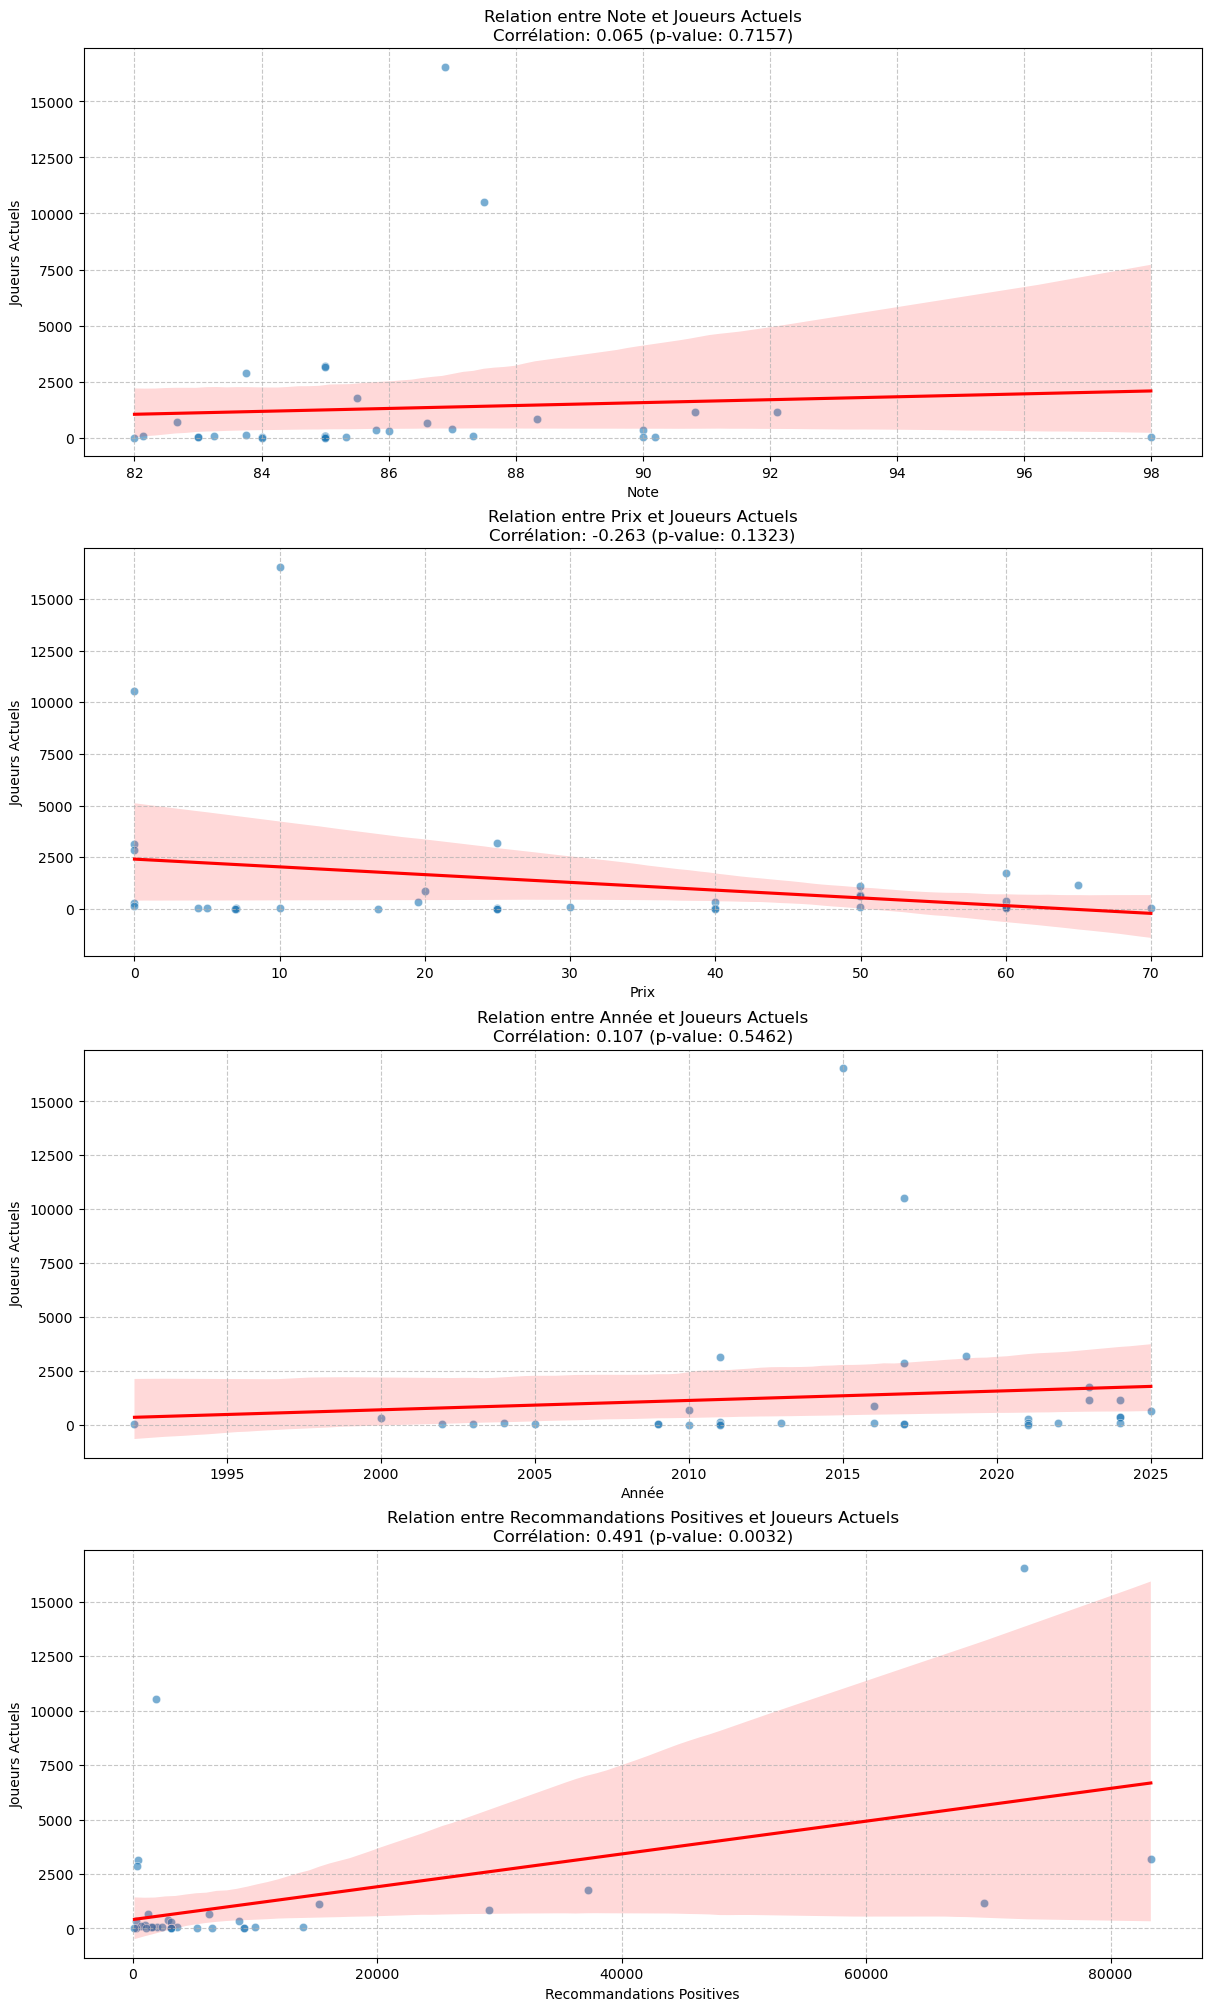

In [53]:
def create_scatter_plots(df, independent_vars, dependent_var):
    n_vars = len(independent_vars)
    fig, axes = plt.subplots(n_vars, 1, figsize=(12, 5*n_vars), constrained_layout=True)
    
    for i, var in enumerate(independent_vars):
        # Calcul le coefficient de corrélation de Pearson et la p-value
        valid_data = df[[var, dependent_var]].dropna()
        corr, p_value = pearsonr(valid_data[var], valid_data[dependent_var])
        
        # Création du graphique de dispersion
        sns.scatterplot(x=var, y=dependent_var, data=df, alpha=0.6, ax=axes[i])
        
        # Ajout d'une ligne de régression
        sns.regplot(x=var, y=dependent_var, data=df, scatter=False, 
                   line_kws={'color': 'red'}, ax=axes[i])
        
        # Annotation et amélioration du graphique
        axes[i].set_title(f'Relation entre {var} et {dependent_var}\n'
                         f'Corrélation: {corr:.3f} (p-value: {p_value:.4f})')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(dependent_var)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
    plt.show()
    
    return fig

# Application à notre dataframe
independent_vars = ['Note', 'Prix', 'Année', 'Recommandations Positives']
dependent_var = 'Joueurs Actuels'

scatter_plots = create_scatter_plots(df_withoutResume, independent_vars, dependent_var)

Seule la corrélation avec la variables 'Recommandations Positives' est significative, ce qui corrobore les résultats de l'approche statistique (approche 1).  
La visualisation de ces relations met en évidence l'influence des deux points dépassant 10 000 joueurs actuels sur les corrélations observées.  
Ces deux observations, nettement isolées du nuage principal de points, induisent un **effet de levier** plus ou moins important sur les droites de régression. Les exclure du jeu de données pourrait modifier la significativité des corrélations (voire éventuellement inverser leur sens). C'est ce que nous investiguerons par la suite. Cela dit, ces valeurs illustrent tout à fait la forte hétérogénéité du marché, où certains titres rencontrent un succès démesuré.  

#### Adaptation de l'analyse
Je réalise ci-dessous la même analyse **en ôtant les valeurs extrêmes** du nombre de joueurs actuels (outliers), à savoir toutes les valeurs supérieures à 10000 joueurs.

Nombre d'observations après filtrage: 32 (supprimé 2 observations)


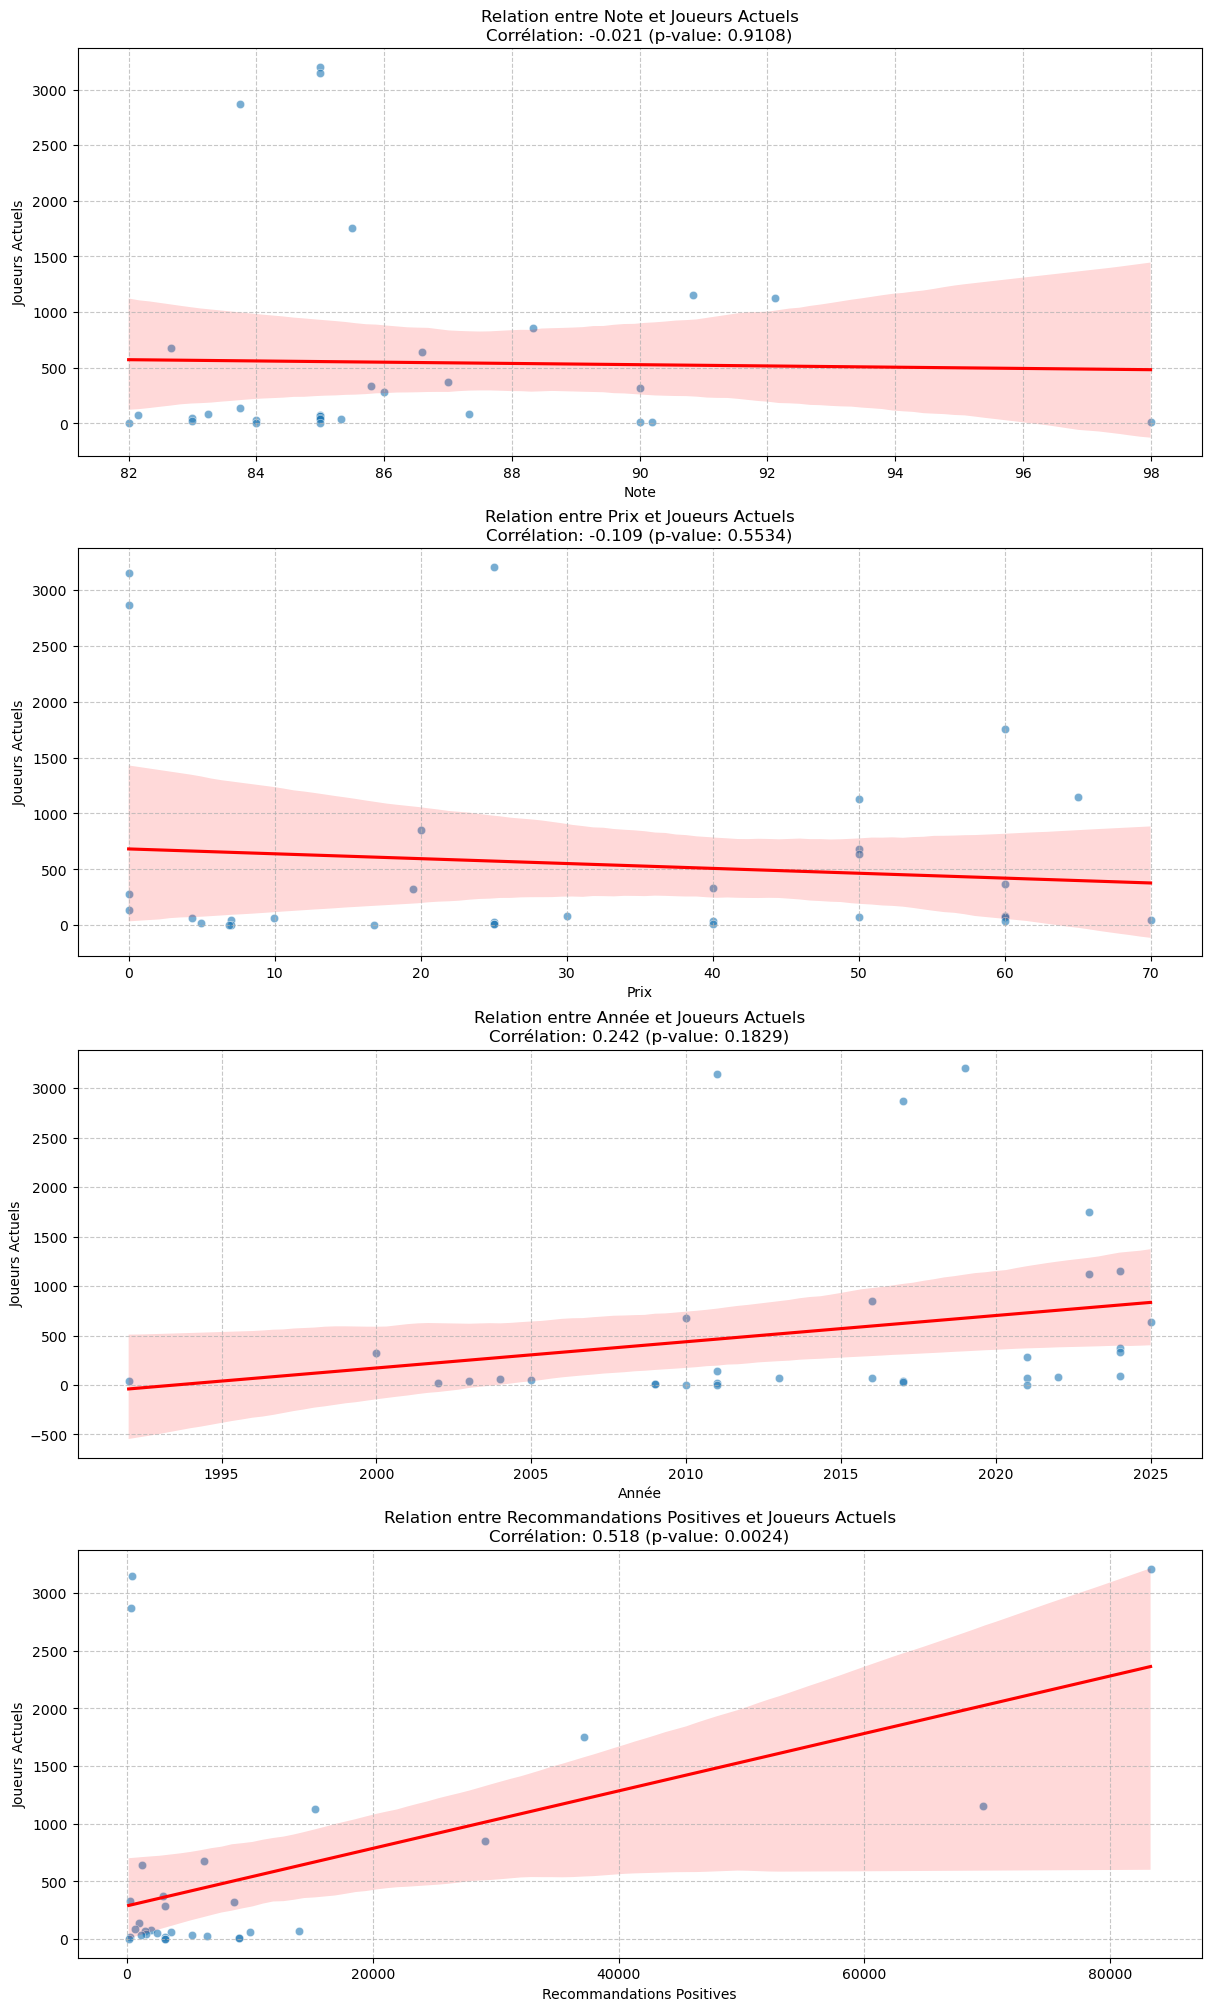

In [55]:
# Mêmes visualisations en enlevant les deux observations à plus 10000 joueurs actuels :

# Fitrage des valeurs extrêmes
df_filtered = df_withoutResume[df_withoutResume['Joueurs Actuels'] <= 10000].copy()
print(f"Nombre d'observations après filtrage: {len(df_filtered)} (supprimé {len(df_withoutResume) - len(df_filtered)} observations)")

# Création des visualisations de dispersion pour les données filtrées
def create_scatter_plots(df, cat_vars, dependent_var):
    n_vars = len(independent_vars)
    fig, axes = plt.subplots(n_vars, 1, figsize=(12, 5*n_vars), constrained_layout=True)
    
    if n_vars == 1:
        axes = [axes]
    
    for i, var in enumerate(cat_vars):
        valid_data = df[[var, dependent_var]].dropna()
        corr, p_value = pearsonr(valid_data[var], valid_data[dependent_var])
        
        sns.scatterplot(x=var, y=dependent_var, data=df, alpha=0.6, ax=axes[i])
        sns.regplot(x=var, y=dependent_var, data=df, scatter=False, 
                   line_kws={'color': 'red'}, ax=axes[i])
        
        axes[i].set_title(f'Relation entre {var} et {dependent_var}\n'
                         f'Corrélation: {corr:.3f} (p-value: {p_value:.4f})')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(dependent_var)
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    plt.show()
    return fig
    
# Création des graphiques avec les données filtrées
scatter_plots = create_scatter_plots(df_filtered, cat_vars, dependent_var)

En éliminant les 2 valeurs extrêmes, le sens de la corrélation change pour la variable 'Note', mais la relation reste non significative.  
Les corrélations pour le 'Prix' et l''Année' restent non significatives également.  
La corrélation reste positive et significative pour les 'Recommandations Positives', et s'accentue légèrement.


Résumé des modèles (trié par RMSE cv croissant):


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,mae_cv,rmse_cv
3,Recommandations Positives,0.502359,-0.447551,341.322706,844.580402,603.658042,1273.481516,373.377219,637.029182
9,Année + Recommandations Positives,0.546163,-0.536203,303.882886,925.207589,576.478336,1311.897993,371.509160,642.761179
12,Note + Année + Recommandations Positives,0.554848,-0.492589,306.690595,921.189493,570.935393,1293.140918,383.258895,647.688497
6,Note + Recommandations Positives,0.511210,-0.401721,342.079545,840.677404,598.265666,1253.160180,410.609528,665.373186
8,Prix + Recommandations Positives,0.509752,-0.352349,358.933735,825.864076,599.156981,1230.892572,425.832443,683.878124
11,Note + Prix + Recommandations Positives,0.516174,-0.328821,356.974173,825.621271,595.220124,1220.137872,444.645814,699.183042
13,Prix + Année + Recommandations Positives,0.566300,-0.389815,339.491393,907.229762,563.543746,1247.826776,441.468181,699.678389
14,Note + Prix + Année + Recommandations Positives,0.570965,-0.370977,338.479577,905.850076,560.504404,1239.341177,451.636362,703.723485
2,Année,0.126490,-0.162610,549.658828,811.294648,799.773317,1141.281339,606.214296,846.983157
5,Note + Année,0.130453,-0.169872,556.218974,827.328729,797.956822,1144.840069,622.869736,852.431762



Meilleur modèle selon RMSE cv:
Variables: ('Recommandations Positives',)
Coefficients: {'Recommandations Positives': 0.034589539507684966}
Intercept: 168.41816512595244


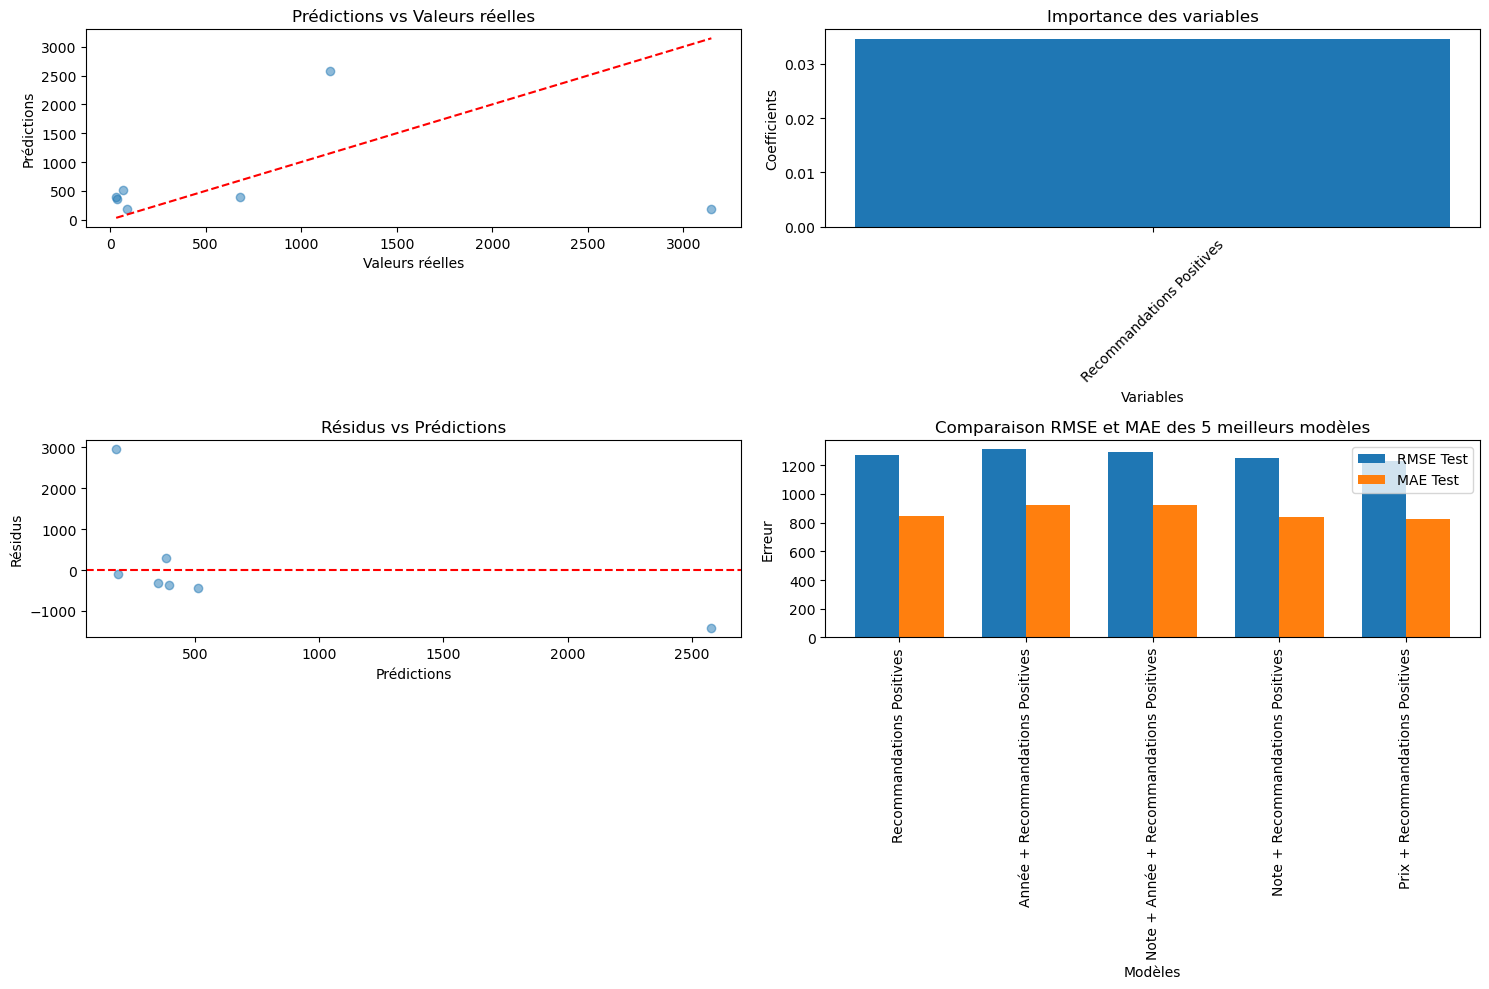

In [58]:
# Analyse via sklearn en enlevant l'outlier de joueurs actuels > 10000 :

# Réitération de l'analyse de régression avec les données filtrées
def test_all_combinations_sklearn(df, cat_vars, dependent_var, test_size=0.2, random_state=12):
    results = {}
    
    X_full = df[cat_vars].copy()
    y_full = df[dependent_var].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=test_size, random_state=random_state)
    
    for r in range(1, len(cat_vars) + 1):
        for vars_combo in combinations(cat_vars, r):
            try:
                vars_list = list(vars_combo)
                X_train_subset = X_train[vars_list].copy()
                X_test_subset = X_test[vars_list].copy()
                
                model = LinearRegression()
                model.fit(X_train_subset, y_train)
                
                y_train_pred = model.predict(X_train_subset)
                y_test_pred = model.predict(X_test_subset)
                
                r2_train = r2_score(y_train, y_train_pred)
                r2_test = r2_score(y_test, y_test_pred)
                
                mae_train = mean_absolute_error(y_train, y_train_pred)
                mae_test = mean_absolute_error(y_test, y_test_pred)
                rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
                rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
                
                cv_mae = -np.mean(cross_val_score(model, X_train_subset, y_train, cv=5, scoring='neg_mean_absolute_error'))
                cv_rmse = np.sqrt(-np.mean(cross_val_score(model, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error')))
                
                model_name = " + ".join(vars_combo)
                results[model_name] = {
                    'r2_train': r2_train,
                    'r2_test': r2_test,
                    'mae_train': mae_train,
                    'mae_test': mae_test,
                    'rmse_train': rmse_train,
                    'rmse_test': rmse_test,
                    'mae_cv': cv_mae,
                    'rmse_cv': cv_rmse,
                    'model': model,
                    'variables': vars_combo,
                    'coefficients': dict(zip(vars_list, model.coef_)),
                    'intercept': model.intercept_
                }
                # print(f"Modèle ajusté avec succès: {model_name}")
            except Exception as e:
                print(f"Erreur avec les variables: {vars_combo}")
                print(f"Message d'erreur: {str(e)}")
                continue
    
    return results, X_train, X_test, y_train, y_test

# Application à notre dataframe filtré
models_results_filtered, X_train, X_test, y_train, y_test = test_all_combinations_sklearn(df_filtered, cat_vars, dependent_var)

# Création d'un dataframe résumant les résultats
def create_summary_sklearn(results):
    if not results:
        print("Aucun modèle n'a pu être ajusté correctement.")
        return None
        
    summary_df = pd.DataFrame({
        'model': list(results.keys()),
        'r2_train': [res['r2_train'] for res in results.values()],
        'r2_test': [res['r2_test'] for res in results.values()],
        'mae_train': [res['mae_train'] for res in results.values()],
        'mae_test': [res['mae_test'] for res in results.values()],
        'rmse_train': [res['rmse_train'] for res in results.values()],
        'rmse_test': [res['rmse_test'] for res in results.values()],
        'mae_cv': [res['mae_cv'] for res in results.values()],
        'rmse_cv': [res['rmse_cv'] for res in results.values()]
    })
    
    # Tri par RMSE cv croissant (meilleur en premier)
    summary_df = summary_df.sort_values('rmse_cv')
    return summary_df

summary_sklearn_filtered = create_summary_sklearn(models_results_filtered)

if summary_sklearn_filtered is not None:
    print("\nRésumé des modèles (trié par RMSE cv croissant):")
    display(summary_sklearn_filtered)
    
    # Affichage du meilleur modèle selon RMSE
    best_model_name = summary_sklearn_filtered.iloc[0]['model']
    best_model = models_results_filtered[best_model_name]['model']
    print("\nMeilleur modèle selon RMSE cv:")
    print(f"Variables: {models_results_filtered[best_model_name]['variables']}")
    print(f"Coefficients: {models_results_filtered[best_model_name]['coefficients']}")
    print(f"Intercept: {models_results_filtered[best_model_name]['intercept']}")

    # Visualisation du résultat du meilleur modèle
    best_vars = list(models_results_filtered[best_model_name]['variables'])
    plt.figure(figsize=(15, 10))
    
    # Prédictions sur le jeu de test
    X_test_best = X_test[best_vars]
    y_pred = best_model.predict(X_test_best)
    
    # Graphique 1: Prédictions vs Valeurs réelles
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title('Prédictions vs Valeurs réelles')
    
    # Graphique 2: Importance des variables
    plt.subplot(2, 2, 2)
    plt.bar(best_vars, best_model.coef_)
    plt.xlabel('Variables')
    plt.ylabel('Coefficients')
    plt.title('Importance des variables')
    plt.xticks(rotation=45)
    
    # Graphique 3: Résidus
    plt.subplot(2, 2, 3)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Prédictions')
    plt.ylabel('Résidus')
    plt.title('Résidus vs Prédictions')
    
    # Graphique 4: Comparaison des métriques RMSE et MAE pour les meilleurs modèles
    plt.subplot(2, 2, 4)
    top5_models = summary_sklearn_filtered.head(5)
    x = np.arange(len(top5_models))
    width = 0.35
    
    plt.bar(x - width/2, top5_models['rmse_test'], width, label='RMSE Test')
    plt.bar(x + width/2, top5_models['mae_test'], width, label='MAE Test')
    plt.xlabel('Modèles')
    plt.ylabel('Erreur')
    plt.title('Comparaison RMSE et MAE des 5 meilleurs modèles')
    plt.xticks(x, top5_models['model'], rotation=90)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

La distribution des résidus n'est toujours pas homogène le long de l'axe des prédictions et le nuage de points des valeurs prédites par rapports aux valeurs réelles est toujours très concentré.   
Les MAE et RMSE restent importantes (d'autant qu'on a enlevé les valeurs extrêmes de joueurs actuels, donc l'échelle est plus petite), avec la RMSE toujours supérieure à la MAE indiquant que le problèmes des valeurs extrêmes n'est pas pleinement résolu.  

Toutefois, on voit que les meilleurs modèles retenus sur la base du RMSE cv incluent tous la variable 'Recommandations Positives', ce qui semble plus véridique.  
Le coefficient relatif aux recommandations positives peut paraître surprenant. En effet, il semble y avoir un **paradoxe** entre l'importance de la variable 'Recommandations Positives' pour l'amélioration du modèle et son coefficient relativement faible (0.03, donc une augmentation moyenne de 0.03 joueurs par unité de recommandation positive supplémentaire vs des coefficients supérieurs à 50 pour le prix et l'année précédemment).  
Cette situation est en fait assez courante et tout à fait compréhensible en analyse multivariée. Elle peut s'expliquer par plusieurs raisons :
- La première confère à l'**échelle des variables** : le coefficient 0.03 paraît faible, mais il faut le considérer par rapport à l'échelle de la variable. Les recommandations positives se quantifient en milliers, tandis que les prix par exemple se situent sur une échelle de 0-70. Ainsi, une augmentation d'*une* unité pour les recommandations a un impact faible, mais **l'effet cumulé peut être énorme**.  
- En outre, cette variable peut capturer une information qui n'est pas présente dans les autres variables, même si son effet direct semble faible : c'est ce qu'on appelle l'**effet de médiation**. Cette variable apporte très certainement une dimension qualitative (satisfaction des joueurs) que les autres variables telles que le prix et l'année ne capturent pas.

### Interprétation finale (approches 1 et 2)
Pour rappel, il existe entre des **différences fondamentales de critères d'optimisation** entre les deux approches employées dans cette étude : *sklearn* (**approche de machine learning**) priorise la performance prédictive (minimise l'erreur de prédiction) quand *statsmodels* (**approche statistique**) se concentre sur l'inférence statistique (significativité des coefficients, p-values).

Il est parfaitement normal d'obtenir des modèles différents avec ces bibliothèques, car elles incarnent des perspectives différentes et n'adoptent pas les mêmes méthodes de sélection de variables.

L'approche 1 (statistique) a généré des R² ajustés relativement satisfaisants (autour de 0.3). Dans le domaine du jeu vidéo, les références comparatives sont limitées, mais des valeurs entre 0.3-0.5 paraissent raisonnables car les comportements des joueurs comportent à la fois des aspects prévisibles et imprévisibles.  
Cette approche a mis en évidence **l'impact déterminant de la variable 'Recommandations Positives'** sur la qualité prédictive des modèles.  
L'approche 2 (machine learning) n'a pas conduit à des résultats congruents, mais ceci est tout à fait normal au regard de la taille très réduite de l'échantillon étudié.    

En conclusion, seul **le nombre de recommandations positives s'affirme comme prédicteur fiable du nombre de joueurs actifs sur les jeux de type RPG**, offrant un potentiel significatif pour des **applications d'inférence statistique** et de **prévision dans l'industrie du jeu vidéo**. Le **prix des jeux** semble être également à considérer.  
Il est intéressant de noter que l'influence prédominante des recommandations positives par rapport aux notes attribuées par les critiques suggère que **l'avis des autres joueurs pèse davantage que celui des professionnels dans le succès d’un jeu.** (*Remarque : je n'ai pas inclus le score Métacritic dans les modèles en raison de trop de valeurs manquantes pour cette variable*).